# Modeling and Predicting Chart Difficulties with Machine Learning

## Business Understanding
### Domain Introduction
Stepmania is an open-source software designed to support many styles of rhythm
game play, but one of its most widely-used formats is for 4-panel “dance games”
(well-known “dance game” examples are Dance Dance Revolution and In The Groove,
but these are specifically-licensed games by Konami and Roxor). The software was
released in 2001 and has since been updated through version 5.3 - the concept behind
this software is to allow players to play a “DDR-like” game with vir"tually boundless
customizations, including custom charts (arrow patterns for songs).  

### Business Problem
The problem that I aim to solve is using exploratory data analysis and statistical learning
to help establish a standardization for song chart difficulty ratings based on various
features of the chart, for example BPM, duration, and quantity of technical elements.  

### Motivation  
While there are many respectable step-artists with expertise in their domains, there has
not been an official and standardized rating system for song difficulties - it is not
uncommon to see players in conversation over whether a song should be “re-rated”
due to various features of its chart. Creating a method of standardization will help
examine which features are the most important in determining difficulty and help
step-artists remove the intuitive/guesswork element from rating their own charts.
The community of rhythm game players is surprisingly large and the amount of
dedication that this community has poured into creating an open-source rendition of
rhythm games is incredible. This software is free and is used for tournament play and
for writing charts and is a staple to any outside-of-arcade dance game player, and is
sometimes employed in small, local arcades as well.

## A Brief Overview of StepMania and "Dance Games"

### What's the point?  
It's a game and you move your feet really fast!

### Data Acquisition

### Chart Features

See [this link](data/feature_dictionary.txt) for a full explanation of each feature that was extracted from the song files.

## Exploratory Data Analysis

In [23]:
#??? maybe include stepartist in info

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_curve, auc, classification_report, log_loss, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA


from xgboost import XGBClassifier, XGBRegressor


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
##display all dataframe columns
pd.set_option('display.max_columns', None)

In [3]:
not_stam = pd.read_csv('data/not_stam.csv')
stam = pd.read_csv('data/stam.csv')

In [4]:
column_names = not_stam.columns

In [5]:
ordered_features = ['title', 'artist', 'song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg', 'bpm_max', 'bpm_min',\
                    'bpm_mode', 'bpm_change_count', 'song_nps', 'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',\
                    'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands', 'quads', 'holds', 'mines', 'rolls',\
                    'crossovers', 'footswitches', 'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',\
                    'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count',\
                    'break_size_max', 'break_size_avg', 'break_total', 'break_size_std', 'difficulty', 'rating']

In [6]:
not_stam_df = not_stam[ordered_features]

In [7]:
stam_df = stam[ordered_features]

In [8]:
len(not_stam_df), len(stam_df)

(4808, 2926)

## Non-Stamina EDA

In [9]:
#not_stam_df.isna().sum()

In [10]:
#not_stam_df.info()

In [11]:
non_numeric_cols = ['title', 'artist', 'difficulty']
numeric_cols = list(not_stam_df.columns.drop(non_numeric_cols))

In [12]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,4808.000000,4808.000000,4808.000000,4808.000000,4.808000e+03,4808.000000,4808.000000,4808.000000,4808.000000,4.808000e+03,4.808000e+03,4.808000e+03,4.808000e+03,4.808000e+03,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,4808.000000,1773.000000,1773.000000,1773.000000,1531.000000,1773.000000,1773.000000,1773.000000,1773.000000,1773.000000,4808.000000
mean,134.433994,477.214434,76.455491,127.731518,8.545380e+04,118.650141,141.624730,8.584027,3.599461,4.686298e+03,2.940412e+03,3.210205e+03,1.416456e+03,3.037067e+03,21.801165,0.183444,0.052413,38.864393,8.481697,3.486897,8.184692,14.552621,3.550333,2.321547,3.410150,4.387895,5.842138,5.820079,5.262831,2.714867,1.792438,6.796954,29.769882,14.492907,65.716864,11.337769,7.497088
std,50.207145,424.772524,30.900622,92.994863,2.886988e+06,43.934407,31.307580,32.944501,3.652527,1.686348e+05,1.056233e+05,1.147700e+05,5.121795e+04,1.076295e+05,25.828948,1.440318,0.741471,41.131565,18.903698,8.686735,9.763098,16.327052,4.165342,3.906833,4.156577,22.516081,16.896380,5.490994,7.135243,3.657608,2.746250,5.480774,16.182127,11.015871,31.639831,9.105002,7.167611
min,4.500124,30.000000,5.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.216409,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000
25%,116.015625,216.000000,63.000000,120.370370,1.280000e+02,86.667000,125.999992,0.000000,1.687649,3.187500e+00,1.715204e+00,1.833333e+00,7.596940e-01,1.666667e+00,5.000000,0.000000,0.000000,10.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,18.000000,6.300000,52.000000,5.418223,4.000000
50%,126.792453,440.000000,72.000000,131.268293,1.500000e+02,127.000000,135.000000,0.000000,3.410614,6.002083e+00,3.465543e+00,3.666667e+00,1.439972e+00,3.666667e+00,15.000000,0.000000,0.000000,30.000000,0.000000,0.000000,5.500000,10.000000,2.000000,1.000000,2.000000,0.000000,0.000000,5.000000,3.000000,1.500000,0.816497,6.000000,27.000000,10.857143,62.000000,8.700575,8.000000
75%,139.857286,649.000000,84.000000,153.920280,1.860000e+02,145.000000,157.000000,4.000000,5.025133,9.533333e+00,5.079051e+00,5.333333e+00,2.225257e+00,5.466667e+00,31.000000,0.000000,0.000000,58.000000,9.000000,3.000000,11.000000,20.000000,5.000000,3.000000,5.000000,0.000000,5.000000,8.000000,7.000000,2.500000,2.217356,9.000000,38.000000,19.500000,74.000000,14.302847,10.000000
max,1955.585592,12540.000000,1135.000000,2142.537313,1.000000e+08,300.000000,352.000000,639.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,676.000000,32.000000,40.000000,1058.000000,343.000000,143.000000,278.000000,459.000000,67.000000,43.000000,95.000000,463.000000,335.000000,140.000000,80.000000,46.500000,24.345431,141.000000,146.000000,89.000000,891.000000,80.610173,420.000000


Some variables to examine:  
`song_seconds` max value of 1955 (that's really long for a non-stamina song)  
`step_count` max value of 12540 (that's also entirely too long)  
`bpm_weighted_avg` min value -1599 (negative weighted averages could throw off the model)  
`bpm_min` min value -160 does not make sense  
`bpm_change_count` of 639 does not make sense in this context  
`rating` value of 420 is most definitely a joke

There was likely a joke chart thrown into one of these packs - the max rating value is 420. So let's take a look at any values that are over 20 because it's extremely unlikely for a technical chart to be playable above that rating.  

First, the ratings:

In [13]:
not_stam_df.loc[not_stam_df['rating'] >= 20]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
770,Deadly force,Noah,110.500000,1084,69,150.000000,150.00,150.00,150.00,0,9.809955,20.000000,9.813512,10.000000,4.143883,10.000000,31,0,0,35,0,0,11,16,0,1,6,1,42,14.0,8.0,3.000000,2.689009,14.0,7.0,1.928571,27.0,1.639150,Edit,21
1408,Weed la Weed,MowtenDoo,99.539591,842,73,176.041477,180.00,173.00,176.00,4,8.458946,12.000000,8.460559,11.733333,4.056128,11.733333,13,0,0,22,0,0,10,3,4,6,3,0,41,2.0,32.0,20.500000,16.263456,3.0,19.0,10.666667,32.0,7.371115,Challenge,420
2016,Speed Complex,Srezcat & Kobaryo,138.750000,988,74,128.000000,128.00,128.00,128.00,0,7.120721,17.066667,7.120721,4.800000,5.549892,4.800000,16,0,0,35,14,1,9,30,2,0,3,0,25,5.0,14.0,5.000000,5.873670,6.0,24.0,8.166667,49.0,9.516652,Easy,20
2792,Do Not Sex To This,The Flashbulb,64.967291,238,36,132.990000,132.99,132.99,132.99,0,3.663382,13.299000,3.663382,3.324750,2.521213,3.324750,0,0,0,107,0,0,8,8,3,0,2,0,2,1.0,2.0,2.000000,NaN,2.0,23.0,17.000000,34.0,8.485281,Hard,69
3664,hot new bonefir remix knife party,PISS SPEARS,96.000000,1342,98,240.061744,243.00,240.00,240.00,4,13.979167,16.000000,13.979167,16.000000,4.052236,16.000000,5,0,0,5,0,0,0,1,0,0,1,0,72,6.0,32.0,12.000000,15.126136,7.0,9.0,3.714286,26.0,3.199702,Challenge,20
3755,HYDRA,96,99.638989,1276,117,277.000000,277.00,277.00,277.00,0,12.806232,18.466667,12.776123,18.466667,6.555248,18.466667,10,0,0,11,0,0,0,0,0,0,0,0,63,5.0,16.0,12.600000,3.974921,6.0,17.0,9.000000,54.0,8.049845,Edit,23
4273,Everyday,Rusko,213.793103,2166,155,174.000000,174.00,174.00,174.00,0,10.131290,17.400000,10.131290,9.425000,6.370936,17.400000,32,0,0,37,17,8,2,35,2,0,1,0,70,22.0,4.0,3.181818,0.394771,23.0,28.0,3.695652,85.0,6.663570,Challenge,22
4274,Everyday,Rusko,213.793103,1374,155,174.000000,174.00,174.00,174.00,0,6.426774,17.400000,6.426774,4.350000,5.289112,3.625000,44,0,0,97,17,8,26,47,2,0,1,0,30,10.0,3.0,3.000000,0.000000,11.0,34.0,11.363636,125.0,14.458719,Hard,20
4275,Everyday,Rusko,213.793103,1374,155,174.000000,174.00,174.00,174.00,0,6.426774,17.400000,6.426774,4.350000,5.289112,3.625000,44,0,0,97,17,8,26,47,2,0,1,0,30,10.0,3.0,3.000000,0.000000,11.0,34.0,11.363636,125.0,14.458719,Medium,20


A lot of these are edits, high step counts, and joke ratings. It's safe to remove them entirely. But first let's look at the tail end most songs with ratings of 18 and higher.

In [14]:
not_stam_df.loc[not_stam_df['rating'] >= 18]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
770,Deadly force,Noah,110.500000,1084,69,150.000000,150.00,150.00,150.00,0,9.809955,20.000000,9.813512,10.000000,4.143883,10.000000,31,0,0,35,0,0,11,16,0,1,6,1,42,14.0,8.0,3.000000,2.689009,14.0,7.0,1.928571,27.0,1.639150,Edit,21
1123,Hay Fields,ICE,146.823529,862,104,170.000000,170.00,170.00,170.00,0,5.870994,22.666667,5.870994,4.958333,3.827461,3.541667,6,0,0,215,58,14,5,57,1,2,7,0,9,8.0,2.0,1.125000,0.353553,9.0,45.0,10.555556,95.0,13.712322,Easy,18
1403,Send My Love To Mars,virt,185.600000,2001,174,225.000000,225.00,225.00,225.00,0,10.781250,15.000000,10.781250,15.000000,4.768360,15.000000,0,0,0,158,0,8,1,6,1,2,4,0,92,5.0,38.0,18.400000,16.682326,6.0,30.0,13.666667,82.0,11.360751,Challenge,18
1408,Weed la Weed,MowtenDoo,99.539591,842,73,176.041477,180.00,173.00,176.00,4,8.458946,12.000000,8.460559,11.733333,4.056128,11.733333,13,0,0,22,0,0,10,3,4,6,3,0,41,2.0,32.0,20.500000,16.263456,3.0,19.0,10.666667,32.0,7.371115,Challenge,420
2016,Speed Complex,Srezcat & Kobaryo,138.750000,988,74,128.000000,128.00,128.00,128.00,0,7.120721,17.066667,7.120721,4.800000,5.549892,4.800000,16,0,0,35,14,1,9,30,2,0,3,0,25,5.0,14.0,5.000000,5.873670,6.0,24.0,8.166667,49.0,9.516652,Easy,20
2792,Do Not Sex To This,The Flashbulb,64.967291,238,36,132.990000,132.99,132.99,132.99,0,3.663382,13.299000,3.663382,3.324750,2.521213,3.324750,0,0,0,107,0,0,8,8,3,0,2,0,2,1.0,2.0,2.000000,NaN,2.0,23.0,17.000000,34.0,8.485281,Hard,69
2914,WANDERLUST,THE QUICK BROWN FOX,128.640000,1305,134,250.000000,250.00,250.00,250.00,0,10.144590,16.666667,10.144590,10.416667,4.724433,8.333333,6,0,0,47,0,9,0,1,0,0,1,0,34,17.0,16.0,2.000000,3.622844,18.0,34.0,5.555556,100.0,8.368163,Challenge,18
2918,18 Pendulum Songs at the Same Time,Pendulum,164.137931,1105,119,174.000000,174.00,174.00,174.00,0,6.732143,11.600000,6.732143,5.800000,3.899841,11.600000,53,0,0,51,16,4,3,12,1,2,2,0,41,2.0,25.0,20.500000,6.363961,3.0,48.0,26.000000,78.0,19.467922,Challenge,18
3663,hot new bonefir remix knife party,PISS SPEARS,96.000000,1121,98,240.061744,243.00,240.00,240.00,4,11.677083,16.000000,11.677083,10.000000,4.213999,16.000000,5,0,0,29,0,0,0,2,0,0,2,0,40,8.0,8.0,5.000000,3.023716,9.0,9.0,6.444444,58.0,3.004626,Hard,18
3664,hot new bonefir remix knife party,PISS SPEARS,96.000000,1342,98,240.061744,243.00,240.00,240.00,4,13.979167,16.000000,13.979167,16.000000,4.052236,16.000000,5,0,0,5,0,0,0,1,0,0,1,0,72,6.0,32.0,12.000000,15.126136,7.0,9.0,3.714286,26.0,3.199702,Challenge,20


This only represents 14 songs out of over 4800. This can be considered safe to drop entirely.

In [15]:
to_drop = not_stam_df.loc[not_stam_df['rating'] >= 18].index

not_stam_df = not_stam_df.drop(to_drop)

In [16]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,4794.000000,4794.000000,4794.000000,4794.000000,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.000000,4.794000e+03,4.794000e+03,4.794000e+03,4.794000e+03,4.794000e+03,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,1759.000000,1759.000000,1759.000000,1518.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,4794.000000
mean,134.415241,475.045682,76.353150,127.544427,8.570279e+04,118.437189,141.478246,8.606592,3.584101,4.699936e+03,2.948973e+03,3.219553e+03,1.420579e+03,3.045907e+03,21.809554,0.183980,0.052566,38.780559,8.477472,3.484564,8.187526,14.539841,3.556946,2.325615,3.413016,4.400501,5.735920,5.801023,5.189312,2.673196,1.758797,6.778283,29.801592,14.529166,65.688459,11.354240,7.367751
std,50.211110,422.772163,30.816556,93.034979,2.891197e+06,43.754998,31.142981,32.989810,3.643527,1.688807e+05,1.057773e+05,1.149373e+05,5.129264e+04,1.077865e+05,25.848840,1.442386,0.742548,41.041381,18.912914,8.695793,9.766227,16.315370,4.169098,3.910823,4.160965,22.547726,16.756648,5.484198,7.033156,3.587513,2.676840,5.474604,16.205024,11.039135,31.626062,9.129039,3.852232
min,4.500124,30.000000,5.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.216409,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000
25%,116.015625,215.250000,63.000000,120.358209,1.280000e+02,85.333000,125.439750,0.000000,1.683673,3.187500e+00,1.710209e+00,1.823438e+00,7.574566e-01,1.666667e+00,5.000000,0.000000,0.000000,10.000000,0.000000,0.000000,2.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,18.000000,6.300000,52.000000,5.412725,4.000000
50%,126.767013,438.000000,72.000000,131.126178,1.500000e+02,126.000000,135.000000,0.000000,3.401352,6.000000e+00,3.458685e+00,3.666667e+00,1.435628e+00,3.666667e+00,15.000000,0.000000,0.000000,30.000000,0.000000,0.000000,6.000000,10.000000,2.000000,1.000000,2.000000,0.000000,0.000000,5.000000,3.000000,1.500000,0.816497,6.000000,27.000000,10.875000,62.000000,8.713700,8.000000
75%,139.856993,647.750000,84.000000,153.920280,1.860000e+02,145.000000,157.000000,4.000000,5.014260,9.466667e+00,5.060722e+00,5.333333e+00,2.219493e+00,5.437500e+00,31.000000,0.000000,0.000000,58.000000,9.000000,3.000000,11.000000,20.000000,5.000000,3.000000,5.000000,0.000000,5.000000,8.000000,7.000000,2.500000,2.176574,9.000000,38.000000,19.500000,74.000000,14.305094,10.000000
max,1955.585592,12540.000000,1135.000000,2142.537313,1.000000e+08,300.000000,352.000000,639.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,676.000000,32.000000,40.000000,1058.000000,343.000000,143.000000,278.000000,459.000000,67.000000,43.000000,95.000000,463.000000,335.000000,140.000000,80.000000,46.500000,24.345431,141.000000,146.000000,89.000000,891.000000,80.610173,17.000000


Still some odd values with max `song_seconds`, `step_count`, and `measure_count` - some of these are much more representative of stamina-like data. Let's examine the 90th percentile of both values to see how outlying these values are.

In [17]:
max_seconds = not_stam_df.song_seconds.quantile(.90)
max_step_count = not_stam_df.step_count.quantile(.90)

print(f'90% of non-stamina songs are under {max_seconds} seconds long.')
print(f'90% of non-stamina songs have under {max_step_count} steps.')

90% of non-stamina songs are under 164.00154545454566 seconds long.
90% of non-stamina songs have under 825.6999999999998 steps.


Let's find the songs that have either one.

In [18]:
not_stam_df.loc[(not_stam_df['song_seconds'] > max_seconds) | (not_stam_df['step_count'] > max_step_count)]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
26,Break It Down,JayKode,144.000000,904,90,150.000000,150.000000,150.000000,150.000000,0,6.277778,12.500000,6.277778,6.250000,2.426792,5.625000,66,2,0,41,3,6,11,26,5,0,5,0,10,7.0,4.0,1.428571,1.133893,8.0,24.0,10.000000,80.0,6.546537,Challenge,12
31,Chronos,JAGGS & Dropgun,174.532750,520,60,129.438202,192.000000,64.000000,128.000000,25,2.979384,8.800000,3.176045,2.933333,1.687638,2.666667,50,0,0,40,10,4,7,26,3,0,2,2,1,1.0,1.0,1.000000,NaN,2.0,30.0,29.500000,59.0,0.707107,Challenge,10
32,Chronos,JAGGS & Dropgun,174.532750,369,60,129.438202,192.000000,64.000000,128.000000,25,2.114216,8.800000,2.369335,2.133333,1.706676,2.133333,19,0,0,44,35,0,8,15,3,10,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hard,9
33,Chronos,JAGGS & Dropgun,174.532750,238,60,129.438202,192.000000,64.000000,128.000000,25,1.363641,4.800000,1.530605,1.333333,1.152747,1.333333,2,0,0,39,0,0,7,16,4,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Medium,6
34,Chronos,JAGGS & Dropgun,174.532750,161,60,129.438202,192.000000,64.000000,128.000000,25,0.922463,3.200000,1.070202,0.990476,0.782804,1.066667,16,0,0,9,0,0,1,9,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Easy,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4753,Pixel,Tokyo Machine,138.750000,836,74,128.000000,128.000000,128.000000,128.000000,0,6.025225,10.133333,6.025225,6.133333,2.474508,5.333333,18,0,0,74,0,0,25,5,24,43,5,0,17,14.0,2.0,1.214286,0.425815,15.0,20.0,3.800000,57.0,4.783902,Challenge,12
4778,Spider's Blood,"DJ Command feat. Takahito ""Rute"" Koshida",134.634146,865,92,164.000000,164.000000,164.000000,164.000000,0,6.424819,10.933333,6.424819,6.833333,2.356403,7.516667,77,0,0,75,28,0,5,14,0,0,0,0,5,5.0,1.0,1.000000,0.000000,6.0,33.0,14.500000,87.0,10.014989,Challenge,11
4783,Stay the Course,RichaadEB,125.931559,912,69,131.500000,131.500000,131.500000,131.500000,0,7.242029,13.150000,7.242029,7.122917,2.731303,6.027083,20,0,0,62,12,0,7,6,0,0,0,0,32,9.0,7.0,3.555556,2.297341,10.0,7.0,3.700000,37.0,2.162817,Challenge,13
4793,WiFi Tears,Slips & Slurs x Mihka!,145.000827,958,92,152.274994,152.274994,152.274994,152.274994,0,6.606859,15.227499,6.606859,6.344791,4.172929,10.151666,45,0,0,50,4,1,13,3,13,6,1,0,31,11.0,7.0,2.818182,2.040499,12.0,15.0,5.083333,61.0,4.378840,Challenge,14


814 songs. This is a considerable amount of data but it will more accurately represent songs that are 'not stamina'.

In [19]:
to_drop2 = not_stam_df.loc[(not_stam_df['song_seconds'] > max_seconds) | (not_stam_df['step_count'] > max_step_count)].index

not_stam_df = not_stam_df.drop(to_drop2)

Looks like there are a LOT of beginner (level 1) charts, which is interesting. Let's see what's up.

In [20]:
not_stam_df.loc[not_stam_df['rating'] == 1]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
9,666!,Getter & Ghastly,129.414000,73,61,131.043357,192.000000,64.000000,128.000000,73,0.564081,2.133333,0.657622,0.609524,0.548421,0.000000,25,0,0,3,0,0,0,0,0,0,0,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
14,99plus,VITICZ & Usica,106.875000,74,57,128.000000,128.000000,128.000000,128.000000,0,0.692398,1.600000,0.692398,0.533333,0.532999,0.533333,18,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
19,Across the Ocean,zircon,114.710154,60,70,165.727483,195.000000,130.000000,195.000000,68,0.523057,1.083333,0.536510,0.541667,0.265213,0.541667,1,0,0,10,0,0,2,5,2,3,2,139,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
30,Break It Down,JayKode,144.000000,91,88,150.000000,150.000000,150.000000,150.000000,0,0.631944,1.250000,0.646307,0.625000,0.306316,0.625000,5,0,0,9,0,0,2,2,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
40,Crew,GoldLink,114.308154,55,65,130.000023,195.000000,86.667000,130.000000,3,0.481156,1.625000,0.500755,0.541667,0.352717,0.541667,1,0,0,6,0,0,0,0,0,1,1,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,Stay the Course,RichaadEB,125.931559,87,68,131.500000,131.500000,131.500000,131.500000,0,0.690851,1.095833,0.701011,0.547917,0.297039,0.547917,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4792,Swing Break,The McMash Clan feat. Kate Mullins,124.363636,72,56,110.000000,110.000000,110.000000,110.000000,0,0.578947,0.916667,0.589286,0.458333,0.272408,0.458333,3,0,0,0,0,0,4,2,4,5,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4797,WiFi Tears,Slips & Slurs x Mihka!,145.000827,97,88,152.274994,152.274994,152.274994,152.274994,0,0.668962,1.268958,0.699369,0.634479,0.385276,0.634479,2,0,0,0,0,0,2,17,2,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1
4802,Yamatanoorochi,Zekk,100.114286,82,73,175.000000,175.000000,175.000000,175.000000,0,0.819064,1.458333,0.819064,0.729167,0.420022,0.729167,2,0,0,0,0,0,4,6,4,4,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,1


In [21]:
not_stam_df.loc[not_stam_df['rating'] == 1].difficulty.value_counts()

Beginner     510
Challenge      2
Medium         1
Hard           1
Name: difficulty, dtype: int64

Not a big deal, but let's drop anything that isn't labelled as 'Beginner' with a rating of 1. These add no value to the data set.

In [22]:
to_drop3 = not_stam_df.loc[(not_stam_df['rating'] == 1) & (not_stam_df['difficulty'] != 'Beginner')].index

not_stam_df = not_stam_df.drop(to_drop3)

In [23]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,3976.000000,3976.000000,3976.000000,3976.000000,3.976000e+03,3976.000000,3976.000000,3976.000000,3976.000000,3.976000e+03,3.976000e+03,3.976000e+03,3.976000e+03,3.976000e+03,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,3976.000000,1195.000000,1195.000000,1195.000000,985.000000,1195.000000,1195.000000,1195.000000,1195.000000,1195.000000,3976.000000
mean,124.053055,392.016097,71.556087,128.445408,1.032957e+05,119.409224,139.437185,7.128270,3.297006,5.664939e+03,3.554630e+03,3.880836e+03,1.712368e+03,3.671333e+03,19.682847,0.125503,0.044517,35.612676,7.284457,3.057344,7.588531,13.526157,3.459759,2.305584,3.045775,4.068913,2.445171,4.585774,3.067782,1.818037,0.989008,5.564854,30.878661,15.958787,61.855230,12.085204,6.794266
std,15.924041,223.136476,14.453356,91.520214,3.174489e+06,41.727158,29.124917,24.368784,3.747383,1.854303e+05,1.161430e+05,1.262006e+05,5.631914e+04,1.183488e+05,20.354179,1.140272,0.772665,34.662417,17.085499,7.846722,7.777032,14.107452,3.907534,3.835344,3.461547,21.938801,5.403936,3.099138,3.177273,1.716371,1.464348,3.080946,15.481318,10.967610,15.457944,9.297410,3.586828
min,4.500124,30.000000,7.000000,-1599.514601,9.000000e+01,-160.000000,47.000000,0.000000,0.270833,4.166667e-01,1.501618e-01,0.000000e+00,8.859642e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,4.000000,1.555556,14.000000,0.000000,1.000000
25%,114.375000,193.000000,61.000000,120.973881,1.280000e+02,95.000000,125.000000,0.000000,1.580840,2.900000e+00,1.594206e+00,1.650000e+00,7.023809e-01,1.562500e+00,5.000000,0.000000,0.000000,9.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,3.000000,19.000000,7.387500,52.000000,5.862765,4.000000
50%,123.870968,392.000000,70.000000,130.000000,1.450000e+02,128.000000,132.000000,0.000000,3.184235,5.408333e+00,3.224247e+00,3.458333e+00,1.306355e+00,3.437500e+00,13.000000,0.000000,0.000000,27.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,4.000000,2.000000,1.250000,0.547723,5.000000,29.000000,12.600000,61.000000,9.551863,7.000000
75%,133.928342,576.000000,80.000000,150.000000,1.786250e+02,144.000000,152.000000,3.000000,4.647012,8.533333e+00,4.688511e+00,4.999250e+00,2.030695e+00,5.066216e+00,28.000000,0.000000,0.000000,54.000000,6.000000,2.000000,11.000000,19.000000,5.000000,3.000000,4.000000,0.000000,2.000000,7.000000,4.000000,2.000000,1.253566,8.000000,39.000000,22.500000,71.000000,15.203501,10.000000
max,164.001545,825.000000,160.000000,2142.537313,1.000000e+08,282.991000,352.000000,363.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,180.000000,32.000000,40.000000,291.000000,236.000000,116.000000,61.000000,145.000000,47.000000,41.000000,28.000000,463.000000,40.000000,16.000000,28.000000,28.000000,11.313708,17.000000,107.000000,60.500000,121.000000,72.124892,16.000000


Now let's address `bpm_weighted_avg` and `bpm_change_count`.

In [24]:
weighted_bpm_median = not_stam_df.bpm_weighted_avg.median()

In [25]:
not_stam_df[not_stam_df['bpm_weighted_avg'] < 0] = weighted_bpm_median

In [26]:
max_bpm_avg = round(not_stam_df.bpm_weighted_avg.quantile(.9))

print(f'90% of not-stamina songs have a max bpm weighted average of {max_bpm_avg} or less.')

90% of not-stamina songs have a max bpm weighted average of 173 or less.


In [27]:
not_stam_df = not_stam_df.drop(not_stam_df.loc[not_stam_df['bpm_weighted_avg'] > max_bpm_avg].index)

In [28]:
max_bpm_change = round(not_stam_df.bpm_change_count.quantile(.9))

print(f'90% of not-stamina songs have {max_bpm_change} bpm changes or fewer.')

90% of not-stamina songs have 25 bpm changes or fewer.


In [29]:
not_stam_df = not_stam_df.drop(not_stam_df.loc[not_stam_df['bpm_change_count'] > max_bpm_change].index)

In [30]:
len(not_stam_df)

3217

The columns listed above with NaN values are largely attributed to stamina data as they measure 'streams' and 'breaks' and because technical songs do not contain very large amounts of long continuous streaming, these can be safe to drop as they do not add meaningful value to this data.

In [31]:
cols_to_drop = ['stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count', 'break_size_max',\
               'break_size_avg', 'break_total', 'break_size_std']

not_stam_df = not_stam_df.drop(columns = cols_to_drop, axis = 1)

In [32]:
not_stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating
count,3217.000000,3217.000000,3217.000000,3217.000000,3.217000e+03,3217.000000,3217.000000,3217.000000,3217.000000,3.217000e+03,3.217000e+03,3.217000e+03,3.217000e+03,3.217000e+03,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000,3217.000000
mean,124.182419,385.348461,68.938452,131.786921,1.244989e+05,120.753873,133.666080,1.804165,3.247485,6.999817e+03,4.392447e+03,4.795578e+03,2.115972e+03,4.536650e+03,19.154803,0.136773,0.052533,34.385141,6.373640,2.816910,7.529375,13.364936,3.434877,2.344731,3.004663,0.838359,2.578178,6.738887
std,15.436889,221.441517,11.900628,19.064512,3.524529e+06,30.386498,20.983277,4.246107,4.040162,2.061311e+05,1.291087e+05,1.402890e+05,6.260648e+04,1.315604e+05,19.661081,1.214524,0.857024,33.927591,15.208715,7.464909,7.770925,14.229545,3.942710,3.953975,3.456955,4.051363,5.607736,3.582306
min,4.500124,30.000000,7.000000,58.741500,9.000000e+01,4.250000,47.000000,0.000000,0.270833,4.412250e-01,2.708333e-01,0.000000e+00,9.499105e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,114.375000,188.000000,61.000000,122.000000,1.260000e+02,105.000000,124.999992,0.000000,1.542846,2.708333e+00,1.554528e+00,1.625000e+00,6.817628e-01,1.600000e+00,5.000000,0.000000,0.000000,8.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,123.870968,383.000000,68.000000,129.107843,1.350000e+02,128.000000,130.000000,0.000000,3.110100,5.175000e+00,3.135768e+00,3.313333e+00,1.247554e+00,3.333333e+00,13.000000,0.000000,0.000000,26.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,7.000000
75%,133.740458,569.000000,76.000000,145.000000,1.560420e+02,140.000000,148.000000,2.000000,4.583524,8.466667e+00,4.613636e+00,4.875000e+00,1.958338e+00,5.000000e+00,28.000000,0.000000,0.000000,51.000000,5.000000,2.000000,11.000000,19.000000,5.000000,3.000000,4.000000,0.000000,2.000000,10.000000
max,163.125000,824.000000,120.000000,173.000000,1.000000e+08,173.000000,220.000000,25.000000,132.440785,7.500000e+06,4.598765e+06,5.000000e+06,2.259042e+06,4.583333e+06,157.000000,32.000000,40.000000,291.000000,211.000000,105.000000,61.000000,145.000000,47.000000,41.000000,25.000000,75.000000,40.000000,16.000000


In [33]:
not_stam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3217 entries, 0 to 4807
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3217 non-null   object 
 1   artist                  3217 non-null   object 
 2   song_seconds            3217 non-null   float64
 3   step_count              3217 non-null   float64
 4   measure_count           3217 non-null   float64
 5   bpm_weighted_avg        3217 non-null   float64
 6   bpm_max                 3217 non-null   float64
 7   bpm_min                 3217 non-null   float64
 8   bpm_mode                3217 non-null   float64
 9   bpm_change_count        3217 non-null   float64
 10  song_nps                3217 non-null   float64
 11  nps_per_measure_max     3217 non-null   float64
 12  nps_per_measure_avg     3217 non-null   float64
 13  nps_per_measure_median  3217 non-null   float64
 14  nps_per_measure_std     3217 non-null   

No NaN values, no weird extreme values, we should be good! Let's visualize.

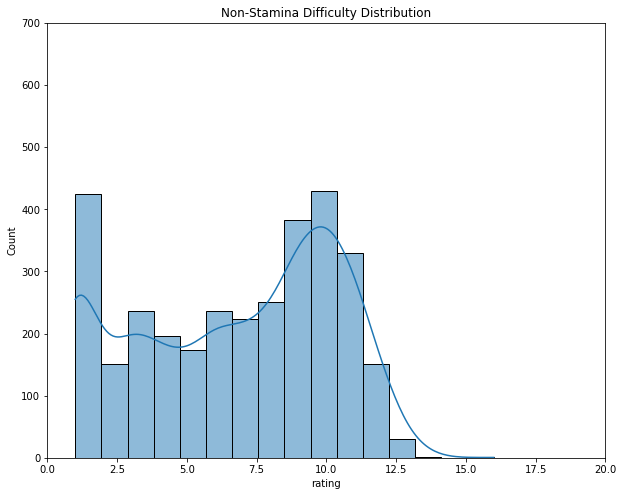

In [34]:
fig, ax = plt.subplots(figsize = (10, 8))
graph = sns.histplot(data = not_stam_df, x = 'rating', kde = True)
graph.set(xlim = (0, 20), ylim = (0, 700))
graph.set(title = "Non-Stamina Difficulty Distribution");

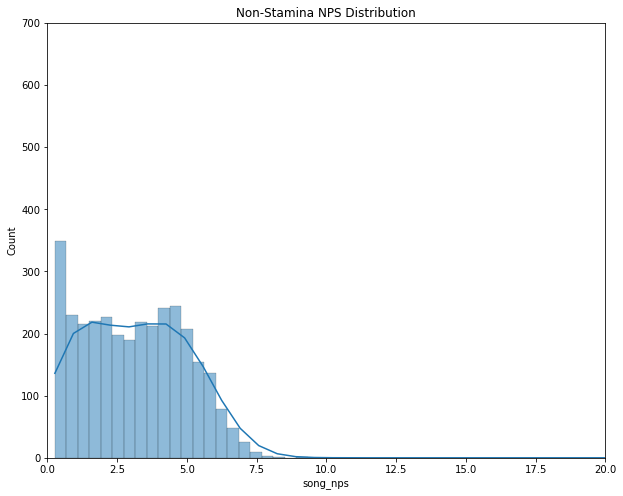

In [35]:
fig, ax = plt.subplots(figsize = (10, 8))
graph = sns.histplot(data = not_stam_df, x = 'song_nps', kde = True)
graph.set(xlim = (0, 20), ylim = (0, 700))
graph.set(title = "Non-Stamina NPS Distribution");

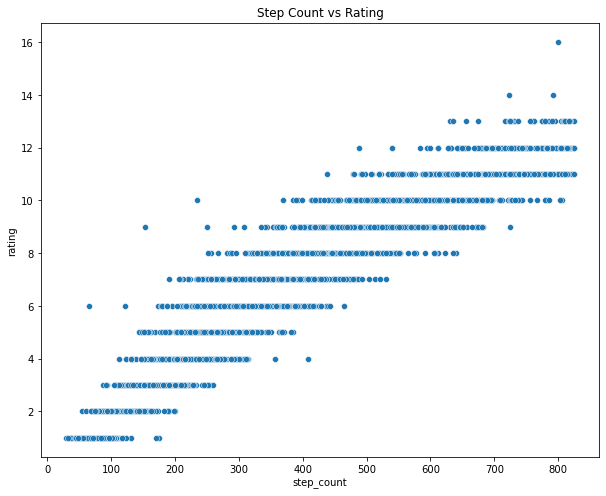

In [36]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'step_count', y = 'rating')
steps.set(title = "Step Count vs Rating");

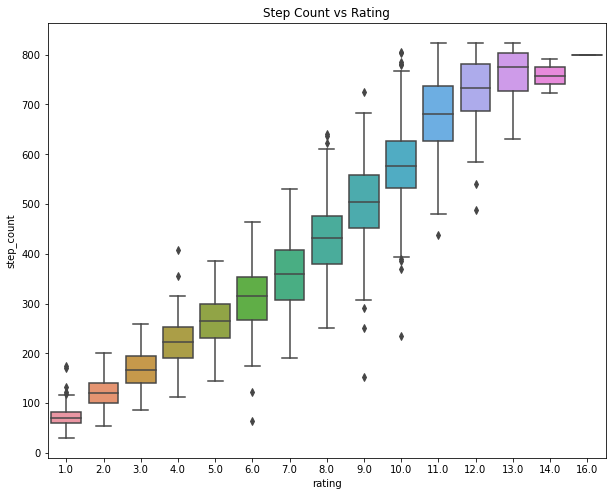

In [37]:
fig, ax = plt.subplots(figsize = (10,8))
step = sns.boxplot(data = not_stam_df, x = 'rating', y = 'step_count')
step.set(title = "Step Count vs Rating");

This is a valuable visualization because you can see how much broader the range is for steps within 8-11 difficulty.

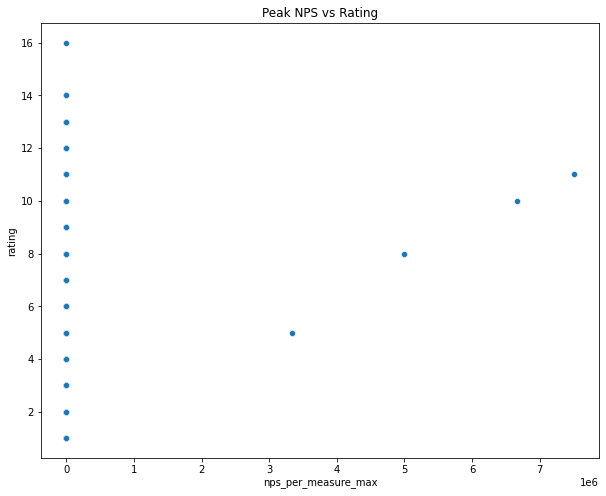

In [38]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'nps_per_measure_max', y = 'rating')
steps.set(title = "Peak NPS vs Rating");

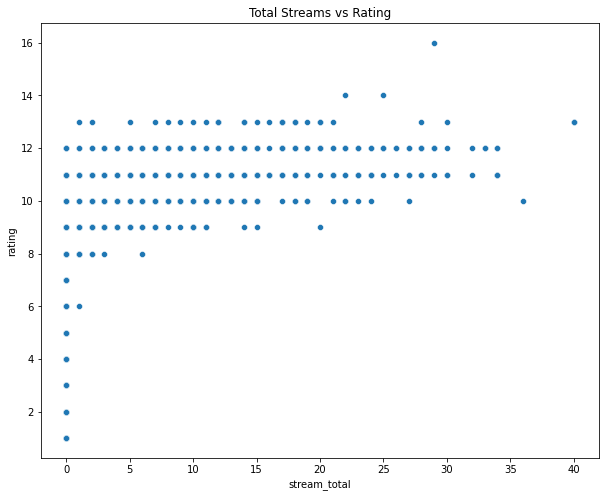

In [39]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'stream_total', y = 'rating')
steps.set(title = "Total Streams vs Rating");

In [40]:
not_stam_df.corr()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating
song_seconds,1.000000,0.088305,0.470955,-0.088165,-0.273598,-0.132636,-0.033659,0.069657,-0.287613,-0.263145,-0.263662,-0.264925,-0.261948,-0.267232,0.047987,-0.010249,-0.012225,0.170726,0.032913,0.074586,0.039542,0.057275,0.061149,0.026051,0.042933,-0.048694,-0.037467,-0.025504
step_count,0.088305,1.000000,0.215326,0.164068,0.011497,0.103320,0.150682,-0.006980,0.448824,0.016589,0.016484,0.016166,0.016835,0.015566,0.564371,0.128457,0.045765,0.512800,0.403427,0.305074,0.474419,0.449849,0.166522,0.001132,0.510360,0.031055,0.615009,0.953092
measure_count,0.470955,0.215326,1.000000,0.702266,-0.044296,0.365461,0.715080,0.026425,0.011484,-0.042602,-0.042687,-0.042892,-0.042409,-0.043265,0.147645,-0.023297,-0.049804,0.182956,0.091794,0.109817,0.046756,0.067020,0.049929,0.003068,0.054063,-0.028009,-0.027409,0.079293
bpm_weighted_avg,-0.088165,0.164068,0.702266,1.000000,0.037989,0.618203,0.901533,-0.075590,0.114185,0.036537,0.036608,0.036783,0.036370,0.037104,0.107695,0.001765,0.009531,0.052917,0.047623,0.068761,0.020294,0.022158,0.004832,-0.006518,0.033545,0.019378,0.006052,0.099205
bpm_max,-0.273598,0.011497,-0.044296,0.037989,1.000000,-0.012497,-0.039797,0.118008,0.859628,0.961790,0.963678,0.968297,0.957418,0.976727,0.020811,0.032345,-0.002163,0.011820,-0.002607,0.000865,0.021436,0.000954,-0.008369,-0.014233,0.025473,-0.007291,0.034118,0.017349
bpm_min,-0.132636,0.103320,0.365461,0.618203,-0.012497,1.000000,0.446141,-0.539505,0.046628,-0.012010,-0.012034,-0.012091,-0.011956,-0.012196,0.037534,0.011279,0.024949,-0.006182,-0.021643,0.029529,0.025125,-0.009440,-0.000458,0.013389,-0.005078,-0.098776,0.038180,0.057405
bpm_mode,-0.033659,0.150682,0.715080,0.901533,-0.039797,0.446141,1.000000,-0.003102,0.038602,-0.038277,-0.038353,-0.038537,-0.038104,-0.038872,0.103568,-0.000465,0.023504,0.044548,0.030039,0.053593,0.004417,0.009806,-0.015803,-0.034271,0.021838,-0.012760,-0.010662,0.087144
bpm_change_count,0.069657,-0.006980,0.026425,-0.075590,0.118008,-0.539505,-0.003102,1.000000,0.092966,0.113474,0.113696,0.114241,0.112958,0.115235,0.012431,-0.016330,0.009749,0.050770,0.094545,0.047094,-0.006300,0.051947,0.009082,-0.020962,0.052110,0.307053,-0.026310,0.006981
song_nps,-0.287613,0.448824,0.011484,0.114185,0.859628,0.046628,0.038602,0.092966,1.000000,0.893960,0.894053,0.893514,0.893845,0.892251,0.262986,0.094348,0.019999,0.217258,0.175579,0.128351,0.236942,0.200872,0.064235,-0.014704,0.251140,0.014759,0.319580,0.446941
nps_per_measure_max,-0.263145,0.016589,-0.042602,0.036537,0.961790,-0.012010,-0.038277,0.113474,0.893960,1.000000,0.999842,0.999436,0.999539,0.998130,0.020905,0.042757,-0.002079,0.012405,-0.000083,0.004374,0.036519,0.007970,-0.003423,-0.012815,0.033780,-0.007022,0.045603,0.022842


## Stamina EDA

In [41]:
#stam_df.isna().sum()

In [42]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2926.000000,2926.000000,2926.000000,2926.000000,2.926000e+03,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2926.000000,2535.000000,2535.000000,2535.000000,2449.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2926.000000
mean,288.478922,2168.811347,206.767259,95.135805,7.014561e+03,165.765754,172.792568,2.049897,7.326411,102.399694,17.241969,8.057189,28.674169,9.420610,20.076555,0.093643,0.057758,69.308954,11.993848,3.479494,5.201640,12.503418,3.079631,1.370472,4.185578,0.010595,88.174983,9.392505,30.754635,15.375035,10.028672,10.378453,39.845699,15.941810,111.406867,14.022224,13.221121
std,281.915414,3007.661671,210.489980,2007.431283,1.652309e+05,40.775097,34.768049,16.169283,2.911861,4929.619436,535.026703,3.846674,1375.031132,4.445095,30.308042,1.281604,0.533089,84.899761,47.355819,9.874361,9.546307,20.691362,6.003260,3.479484,6.912153,0.176065,175.218495,11.433906,53.662276,45.550953,13.250906,11.434429,28.889696,16.657728,75.754621,13.007312,4.485111
min,61.286375,20.000000,31.000000,-54098.122537,7.600000e+01,10.000000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.500000,1.000000,0.000000,1.000000
25%,190.285714,1105.250000,123.000000,143.000000,1.540000e+02,140.000000,147.000000,0.000000,5.623307,9.466667,5.639084,5.666667,2.341269,5.933333,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,4.000000,8.000000,4.218900,2.760262,5.000000,20.000000,6.400000,61.000000,6.680687,11.000000
50%,256.633663,1782.000000,187.000000,174.000000,1.740000e+02,174.000000,174.000000,0.000000,7.413709,11.600000,7.431784,7.306250,3.309423,10.333333,8.000000,0.000000,0.000000,45.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,58.000000,7.000000,17.000000,9.000000,6.057758,8.000000,32.000000,10.875000,98.000000,10.919238,13.000000
75%,318.297872,2517.250000,234.000000,192.980000,1.960000e+02,190.800000,194.000000,0.000000,9.195520,13.333333,9.215318,11.333333,4.132390,12.542600,25.000000,0.000000,0.000000,94.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,112.000000,11.000000,34.000000,16.750000,12.417729,12.000000,50.000000,19.000000,147.000000,16.857491,16.000000
max,7089.862103,73602.000000,5059.000000,2897.960243,4.000000e+06,320.000000,320.000000,623.000000,18.614390,266666.683333,28947.848469,35.933333,74382.100838,52.266667,289.000000,40.000000,9.000000,999.000000,712.000000,112.000000,146.000000,224.000000,63.000000,50.000000,97.000000,4.000000,4269.000000,222.000000,2058.000000,2058.000000,189.787249,223.000000,236.000000,136.000000,1038.000000,161.220346,28.000000


Less weird stuff going on in the stamina data but let's check out a few outliers:  
`bpm_weighted_avg` minimum value  of -54098 and maximum value of 2897  
`bpm_change_count` of 623  

In [43]:
stam_df.loc[stam_df['bpm_weighted_avg'] < 0]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
39,End Boss,The Outside Agency,274.000000,3130,274,-559.107621,240.000,160.0,240.00,8,11.423358,20.000000,11.423358,16.000000,6.251415,16.000000,5,0,0,43,0,0,3,8,2,2,2,0,171,7.0,64.0,24.428571,22.262503,8.0,64.0,12.875000,103.0,21.892187,Easy,21.0
40,End Boss,The Outside Agency,274.000000,2589,274,-559.107621,240.000,160.0,240.00,8,9.448905,16.000000,9.448905,8.000000,5.999324,16.000000,5,0,0,68,0,0,3,8,2,2,2,0,110,4.0,33.0,27.500000,9.678154,5.0,79.0,32.800000,164.0,35.933271,Hard,20.0
41,End Boss,The Outside Agency,274.000000,3120,274,-559.107621,240.000,160.0,240.00,8,11.386861,17.000000,11.386861,16.000000,6.216188,16.000000,5,0,0,60,0,0,3,8,2,2,2,0,171,7.0,64.0,24.428571,22.262503,8.0,64.0,12.875000,103.0,21.892187,Challenge,21.0
692,Destination,ZaG-X Vs. Renard,107.162791,759,96,-385.665666,215.000,135.0,215.00,2,7.082682,14.333333,7.082682,6.270833,4.777719,14.333333,16,1,0,3,0,0,0,1,0,0,1,0,23,2.0,12.0,11.500000,0.707107,3.0,32.0,24.333333,73.0,11.590226,Challenge,15.0
707,to Luv me I *** for u,t+pazolite,266.703551,1958,233,-54.271512,220.000,40.0,219.98,26,7.341485,14.666000,7.638755,7.332667,4.010339,7.332667,65,0,7,246,0,0,12,33,7,0,5,0,36,16.0,8.0,2.250000,1.732051,17.0,36.0,11.588235,197.0,12.344325,Challenge,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,Timberwolf,Muzzy,383.847638,2979,282,-88.440869,590.625,87.5,175.00,8,7.760892,11.666667,7.702793,11.666667,4.619721,11.666667,28,0,0,41,95,17,0,2,0,0,1,0,149,9.0,30.0,16.555556,5.077182,10.0,84.0,13.300000,133.0,25.621389,Challenge,15.0
2922,Timberwolf,Muzzy,383.847638,2625,282,-88.440869,590.625,87.5,175.00,8,6.838651,11.666667,6.787456,7.291667,4.194422,11.666667,42,0,0,74,98,23,1,6,1,0,3,0,87,6.0,15.0,14.500000,0.547723,7.0,84.0,27.857143,195.0,30.470907,Hard,14.0
2923,Timberwolf,Muzzy,383.847638,2401,282,-88.440869,590.625,87.5,175.00,8,6.255086,11.666667,6.208259,6.562500,3.871225,11.666667,42,0,0,86,97,23,1,6,1,0,3,0,59,4.0,15.0,14.750000,0.500000,5.0,97.0,44.600000,223.0,43.798402,Medium,13.0
2924,Timberwolf,Muzzy,383.847638,2216,282,-88.440869,590.625,87.5,175.00,8,5.773124,11.666667,5.729905,6.562500,3.339571,5.833333,83,0,0,86,97,41,1,7,1,0,4,0,15,1.0,15.0,15.000000,NaN,2.0,196.0,133.500000,267.0,88.388348,Easy,12.0


Let's replace all negative weighted averages with the 50% percentile - where the majority of the weighted averages fall.

In [44]:
stam_df.bpm_weighted_avg.describe()

count     2926.000000
mean        95.135805
std       2007.431283
min     -54098.122537
25%        143.000000
50%        174.000000
75%        192.980000
max       2897.960243
Name: bpm_weighted_avg, dtype: float64

In [45]:
stam_df.bpm_weighted_avg.median()

174.0

In [46]:
stam_df[stam_df['bpm_weighted_avg'] < 0] = 174

Now we'll take a look at the extreme values of weighted averages.

In [47]:
max_bpm_avg = stam_df.bpm_weighted_avg.quantile(.9)
print(f'90% of these stamina songs are under {max_bpm_avg} bpm.')

90% of these stamina songs are under 216.0 bpm.


In [48]:
max_bpm_change = round(stam_df.bpm_change_count.quantile(.9))
print(f'90% of these stamina songs have under {max_bpm_change} bpm changes.')

90% of these stamina songs have under 4 bpm changes.


In [49]:
stam_df.loc[(stam_df['bpm_change_count'] > max_bpm_change) | (stam_df['bpm_weighted_avg'] > max_bpm_avg)]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
23,Alice in Underground,Demetori,375.692308,4822,407,260.000000,260.000,260.0,260.000,0,12.834971,17.333333,12.834971,13.000000,4.407595,17.333333,0,0,0,2,0,0,0,0,0,0,0,0,184,20.0,16.0,9.200000,5.207282,21.0,41.0,10.619048,223.0,10.210172,Hard,23.0
24,Alice in Underground,Demetori,375.692308,5932,407,260.000000,260.000,260.0,260.000,0,15.789517,17.333333,15.789517,17.333333,3.647888,17.333333,0,0,0,2,0,0,0,0,0,0,0,0,339,8.0,85.0,42.375000,21.619683,9.0,26.0,7.555556,68.0,8.748016,Challenge,25.0
25,âˆ€rkadia,Sakuzyo,281.146090,2358,195,165.848032,168.028,126.3,168.028,6,8.387099,16.666700,8.396592,8.333350,5.950581,8.333350,0,0,0,32,25,0,6,14,2,0,2,0,55,4.0,16.0,13.750000,2.061553,5.0,40.0,28.000000,140.0,13.546217,Hard,19.0
26,âˆ€rkadia,Sakuzyo,281.146090,3066,195,165.848032,168.028,126.3,168.028,6,10.905362,16.666700,10.917964,16.666700,6.951766,16.666700,0,0,0,26,25,0,0,2,0,0,2,0,111,5.0,34.0,22.200000,7.224957,6.0,24.0,14.000000,84.0,9.186947,Challenge,22.0
27,Atome Conscient,La Foudre,331.673820,3635,322,233.000000,233.000,233.0,233.000,0,10.959563,15.533333,10.959563,12.620833,5.248596,15.533333,3,0,0,64,1,4,1,2,1,1,0,0,158,28.0,13.0,5.642857,3.211257,29.0,42.0,5.655172,164.0,10.268801,Hard,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2922,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2923,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0
2924,174,174,174.000000,174,174,174.000000,174.000,174.0,174.000,174,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174,174,174,174,174,174,174,174,174,174,174,174,174,174.0,174.0,174.000000,174.000000,174.0,174.0,174.000000,174.0,174.000000,174,174.0


Here, we are going to drop the outliers instead of replacing the data - it is valid data but is not useful to making a meaningful interpretation of 'stamina' songs.

In [50]:
to_drop = stam_df.loc[(stam_df['bpm_change_count'] > max_bpm_change) | (stam_df['bpm_weighted_avg'] > max_bpm_avg)].index
stam_df = stam_df.drop(to_drop)

In [51]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2411.000000,2411.000000,2411.000000,2411.000000,2.411000e+03,2411.00000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2064.000000,2064.000000,2064.000000,1988.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2411.000000
mean,269.094975,1878.385732,185.133969,165.929504,5.144435e+03,163.55750,165.934886,0.174202,6.976055,10.710988,6.985969,7.611541,3.046910,8.836734,20.173372,0.104936,0.064289,68.732476,10.812526,3.270012,5.201991,12.785566,3.137287,1.386976,4.177934,0.002489,71.442970,8.167636,28.403585,14.392725,9.611497,9.151721,39.300048,16.313587,105.630635,14.032756,12.586064
std,130.191940,1411.016654,95.378646,28.410341,1.410339e+05,31.41931,29.008956,0.699981,2.738277,3.498942,2.734144,3.519875,1.294959,4.042409,30.189701,1.402495,0.565625,77.728110,42.259538,9.003485,9.350763,21.181709,6.149168,3.503522,6.999842,0.049834,85.205305,6.075865,33.574617,21.135917,12.296032,6.070692,28.557048,17.023836,62.935838,12.868225,4.114083
min,61.286375,20.000000,31.000000,9.906467,7.600000e+01,43.50000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,0.500000,1.000000,0.000000,1.000000
25%,193.411765,1069.000000,121.000000,142.000000,1.440000e+02,140.00000,142.000000,0.000000,5.373814,9.204833,5.388968,5.383333,2.255779,5.800000,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,4.000000,8.000000,4.000000,2.697209,5.000000,20.000000,6.545455,59.000000,6.627303,11.000000
50%,256.633663,1711.000000,180.000000,174.000000,1.740000e+02,173.80000,174.000000,0.000000,7.102717,11.600000,7.106021,6.900000,3.152498,9.333333,9.000000,0.000000,0.000000,46.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,53.000000,7.000000,16.000000,8.759615,5.903994,8.000000,32.000000,11.166667,94.000000,10.920982,13.000000
75%,316.497041,2402.000000,225.000000,184.600893,1.857495e+02,182.00000,185.000000,0.000000,8.762662,12.801700,8.768899,10.400000,3.907401,11.666667,26.000000,0.000000,0.000000,96.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,103.000000,11.000000,32.000000,16.511364,12.040676,11.500000,49.000000,19.267857,143.500000,17.064337,15.000000
max,1762.105263,20184.000000,1395.000000,216.000000,4.000000e+06,240.00000,240.000000,4.000000,17.259123,21.929833,16.451659,21.929833,8.186705,21.929833,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,1194.000000,46.000000,512.000000,472.000000,189.787249,47.000000,236.000000,136.000000,531.000000,161.220346,28.000000


In [52]:
stam_df.isna().sum()

title                       0
artist                      0
song_seconds                0
step_count                  0
measure_count               0
bpm_weighted_avg            0
bpm_max                     0
bpm_min                     0
bpm_mode                    0
bpm_change_count            0
song_nps                    0
nps_per_measure_max         0
nps_per_measure_avg         0
nps_per_measure_median      0
nps_per_measure_std         0
nps_per_measure_mode        0
jumps                       0
hands                       0
quads                       0
holds                       0
mines                       0
rolls                       0
crossovers                  0
footswitches                0
crossover_footswitches      0
jacks                       0
invalid_crossovers          0
stop_count                  0
stream_total                0
stream_count              347
stream_size_max           347
stream_size_avg           347
stream_size_std           423
break_coun

To preserve this data, we are going to impute NaNs with the median value:

In [53]:
to_impute = ['stream_count', 'stream_size_max', 'stream_size_avg', 'stream_size_std', 'break_count', 'break_size_max', \
            'break_size_avg', 'break_total', 'break_size_std']

In [54]:
stam_df = stam_df.fillna(0)

In [55]:
stam_df.stream_count = stam_df.stream_count.replace(0, stam_df.stream_count.median())
stam_df.stream_size_max = stam_df.stream_size_max.replace(0, stam_df.stream_size_max.median())
stam_df.stream_size_avg = stam_df.stream_size_avg.replace(0, stam_df.stream_size_avg.median())
stam_df.stream_size_std = stam_df.stream_size_std.replace(0, stam_df.stream_size_std.median())
stam_df.break_count = stam_df.break_count.replace(0, stam_df.break_count.median())
stam_df.break_size_max = stam_df.break_size_max.replace(0, stam_df.break_size_max.median())
stam_df.break_size_avg = stam_df.break_size_avg.replace(0, stam_df.break_size_avg.median())
stam_df.break_total = stam_df.break_total.replace(0, stam_df.break_total.median())
stam_df.break_size_std = stam_df.break_size_std.replace(0, stam_df.break_size_std.median())

In [56]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2411.000000,2411.000000,2411.000000,2411.000000,2.411000e+03,2411.00000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000,2411.000000
mean,269.094975,1878.385732,185.133969,165.929504,5.144435e+03,163.55750,165.934886,0.174202,6.976055,10.710988,6.985969,7.611541,3.046910,8.836734,20.173372,0.104936,0.064289,68.732476,10.812526,3.270012,5.201991,12.785566,3.137287,1.386976,4.177934,0.002489,71.442970,7.855662,26.618416,13.320270,9.047989,8.841145,37.813355,15.321103,101.931149,13.373456,12.586064
std,130.191940,1411.016654,95.378646,28.410341,1.410339e+05,31.41931,29.008956,0.699981,2.738277,3.498942,2.734144,3.519875,1.294959,4.042409,30.189701,1.402495,0.565625,77.728110,42.259538,9.003485,9.350763,21.181709,6.149168,3.503522,6.999842,0.049834,85.205305,5.672741,31.367378,19.729416,11.142605,5.666022,26.661876,15.931245,58.907870,12.003116,4.114083
min,61.286375,20.000000,31.000000,9.906467,7.600000e+01,43.50000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.235702,2.000000,1.000000,0.500000,1.000000,0.500000,1.000000
25%,193.411765,1069.000000,121.000000,142.000000,1.440000e+02,140.00000,142.000000,0.000000,5.373814,9.204833,5.388968,5.383333,2.255779,5.800000,1.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,4.000000,11.000000,4.792857,4.576529,5.000000,22.000000,7.222222,64.000000,7.234931,11.000000
50%,256.633663,1711.000000,180.000000,174.000000,1.740000e+02,173.80000,174.000000,0.000000,7.102717,11.600000,7.106021,6.900000,3.152498,9.333333,9.000000,0.000000,0.000000,46.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,53.000000,6.000000,16.000000,6.941176,4.627430,7.000000,29.000000,9.437500,80.000000,9.330952,13.000000
75%,316.497041,2402.000000,225.000000,184.600893,1.857495e+02,182.00000,185.000000,0.000000,8.762662,12.801700,8.768899,10.400000,3.907401,11.666667,26.000000,0.000000,0.000000,96.000000,2.000000,2.000000,7.000000,16.000000,4.000000,1.000000,5.000000,0.000000,103.000000,10.000000,32.000000,14.781746,10.067274,11.000000,47.000000,17.600000,133.000000,15.539504,15.000000
max,1762.105263,20184.000000,1395.000000,216.000000,4.000000e+06,240.00000,240.000000,4.000000,17.259123,21.929833,16.451659,21.929833,8.186705,21.929833,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,1194.000000,46.000000,512.000000,472.000000,189.787249,47.000000,236.000000,136.000000,531.000000,161.220346,28.000000


In [57]:
len(stam_df)

2411

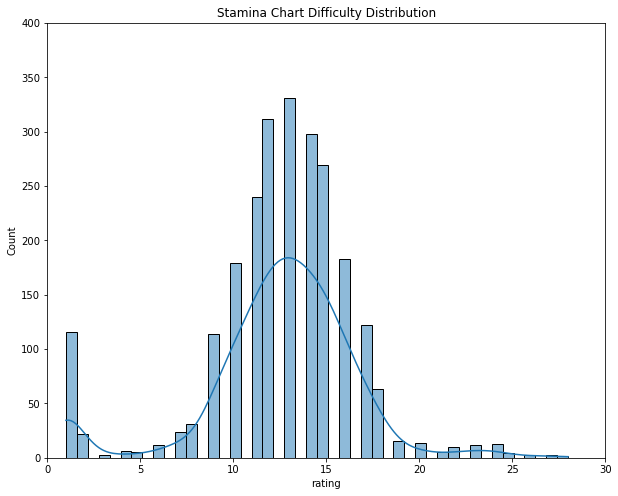

In [58]:
fig, ax = plt.subplots(figsize = (10, 8))
graph = sns.histplot(data = stam_df, x = 'rating', kde = True)
graph.set(xlim = (0, 30), ylim = (0, 400))
graph.set(title = "Stamina Chart Difficulty Distribution");

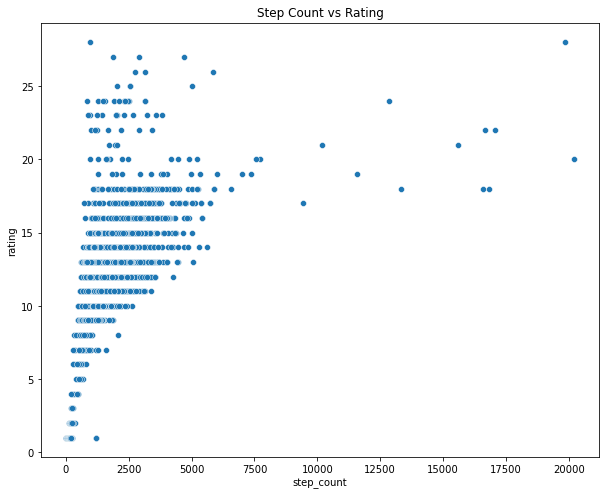

In [59]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = stam_df, x = 'step_count', y = 'rating')
steps.set(title = "Step Count vs Rating");

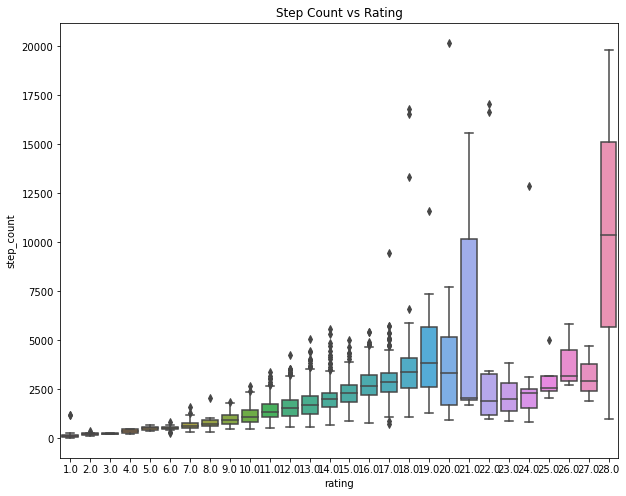

In [60]:
fig, ax = plt.subplots(figsize = (10,8))
step = sns.boxplot(data = stam_df, x = 'rating', y = 'step_count')
step.set(title = "Step Count vs Rating");

The strange spread for difficulty 28 is due to the fact that there are only two songs in this dataset rated 28. In order to have the model exposed to this data, I have elected to keep them in.

In [61]:
stam_df[stam_df['rating'] == 28]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
132,"Go, Go Power Rangers!",Aaron Waters,61.286375,966,48,187.97,187.97,187.97,187.97,0,15.762068,21.929833,15.762068,21.929833,8.186705,21.929833,13,0,0,1,0,0,0,1,0,0,1,0,30,3.0,12.0,10.000000,3.464102,4.0,9.0,4.5,18.0,3.696846,Challenge,28.0
2030,[M] Noise Discipline,Pendulum (Mixed by ITGAlex),1354.482759,19825,982,174.00,174.00,174.00,174.00,0,14.636584,17.400000,14.636584,17.400000,5.702653,17.400000,48,0,0,125,0,0,12,25,2,0,5,0,800,13.0,248.0,61.538462,61.832590,14.0,49.0,13.0,182.0,16.920629,Challenge,28.0


In [62]:
stam_df[stam_df['rating'] == 21]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating
119,DARE,Gorillaz,139.735667,1965,70,120.227,120.227,120.227,120.227,0,14.062265,16.030267,14.062265,16.030267,4.875028,16.030267,1,0,0,3,0,0,0,0,0,0,0,0,60,6.0,23.0,10.000000,6.985700,7.0,4.0,1.428571,10.0,1.133893,Challenge,21.0
166,Stratofortress,Stratovarius,148.000000,1729,111,180.000,180.000,180.000,180.000,0,11.682432,18.000000,11.682432,12.000000,4.533455,12.000000,1,0,0,4,0,0,0,0,0,0,0,0,81,2.0,57.0,40.500000,23.334524,3.0,15.0,10.000000,30.0,4.582576,Medium,21.0
1393,goretrance 9,goreshit,1234.766355,15598,1101,214.000,214.000,214.000,214.000,0,12.632349,14.266667,12.632349,14.266667,3.725383,14.266667,61,0,0,38,0,0,2,12,1,0,7,0,909,36.0,80.0,25.250000,19.838455,37.0,30.0,5.189189,192.0,7.252731,Hard,21.0
1398,HAUNT Sampler Mix,Dustboxxxx & Various Artists,784.000000,10170,686,210.000,210.000,210.000,210.000,0,12.971939,14.000000,12.971939,14.000000,3.250826,14.000000,0,0,0,9,1,0,0,0,0,0,0,0,613,25.0,127.0,24.520000,28.555677,26.0,30.0,2.807692,73.0,5.782866,Challenge,21.0
2104,Watercolour,Pendulum,299.310345,2039,217,174.000,174.000,174.000,174.000,0,6.812327,17.400000,6.812327,5.075000,5.575800,5.800000,44,0,0,236,0,0,8,13,0,0,0,0,69,9.0,16.0,7.666667,7.905694,10.0,47.0,14.800000,148.0,15.310127,Hard,21.0


In [63]:
stam_df.corr()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
song_seconds,1.000000,0.779640,0.934118,-0.077591,-0.048898,-0.082420,-0.077053,0.044616,0.003267,-0.067032,0.004659,0.036259,-0.038521,0.000511,0.060247,-0.049498,-0.063975,0.147651,0.094490,0.103639,0.061036,0.113846,0.054500,0.023077,0.119653,-0.036663,0.656482,0.267764,0.438643,0.230737,0.363131,0.267192,0.293699,0.161240,0.474105,0.200531,0.075504
step_count,0.779640,1.000000,0.851914,0.202220,-0.029038,0.192009,0.204731,-0.001082,0.559600,0.411858,0.559702,0.536681,0.351003,0.474436,0.057807,-0.031600,-0.032896,0.095242,0.055573,0.056415,-0.004749,0.046517,-0.010020,-0.037582,0.091325,-0.017268,0.930679,0.343415,0.651498,0.409516,0.545647,0.341792,0.044363,-0.050118,0.207015,0.007879,0.574043
measure_count,0.934118,0.851914,1.000000,0.237468,-0.041084,0.212814,0.237822,0.041596,0.171856,0.107284,0.171577,0.178534,0.100805,0.143649,0.120165,-0.044512,-0.045762,0.163891,0.092554,0.095993,0.071502,0.133546,0.074990,0.035374,0.144798,-0.030974,0.732046,0.334441,0.473912,0.248764,0.392184,0.333376,0.266096,0.121365,0.488000,0.169066,0.214543
bpm_weighted_avg,-0.077591,0.202220,0.237468,1.000000,0.042715,0.902281,0.976440,-0.032082,0.456177,0.496869,0.453178,0.383813,0.390115,0.387619,0.166419,0.014339,0.051121,0.062421,-0.052329,0.015497,0.014723,0.054083,0.036257,-0.002307,0.077959,0.027891,0.186399,0.194946,0.101556,0.048331,0.094026,0.193650,0.011546,-0.053186,0.132249,-0.020446,0.375405
bpm_max,-0.048898,-0.029038,-0.041084,0.042715,1.000000,0.041125,0.041654,0.092115,0.014091,0.015354,0.013983,0.008719,0.004441,0.019948,-0.012252,-0.002639,-0.004004,-0.001530,-0.009031,-0.011513,-0.013341,-0.012405,-0.014175,-0.013972,-0.010968,0.706665,-0.021686,0.017529,-0.019799,-0.017108,-0.020910,0.017640,-0.026673,-0.022098,-0.026902,-0.024365,0.000776
bpm_min,-0.082420,0.192009,0.212814,0.902281,0.041125,1.000000,0.902569,-0.304280,0.440941,0.455663,0.430871,0.371256,0.368829,0.367702,0.085977,0.016236,0.054810,0.018022,-0.086311,0.003369,-0.007736,0.021039,0.013143,-0.023256,0.041076,0.028858,0.179210,0.168089,0.107266,0.058300,0.107484,0.166735,-0.004321,-0.066909,0.109614,-0.033180,0.356836
bpm_mode,-0.077053,0.204731,0.237822,0.976440,0.041654,0.902569,1.000000,-0.049608,0.458766,0.494257,0.453748,0.385081,0.385741,0.386339,0.161867,0.015000,0.050045,0.050355,-0.084494,0.013045,0.013880,0.052414,0.039196,-0.011990,0.077147,0.027162,0.189610,0.193385,0.108886,0.054688,0.106358,0.192120,0.010471,-0.054434,0.130088,-0.020978,0.377709
bpm_change_count,0.044616,-0.001082,0.041596,-0.032082,0.092115,-0.304280,-0.049608,1.000000,-0.048915,-0.014105,-0.033661,-0.038869,-0.024845,-0.025393,0.121860,-0.015247,-0.028298,0.098795,0.145403,-0.011746,0.071202,0.094202,0.055463,0.054730,0.090721,0.058938,-0.007340,-0.015923,0.000364,0.006522,-0.007365,-0.016141,0.065597,0.075846,0.042938,0.057859,-0.020481
song_nps,0.003267,0.559600,0.171856,0.456177,0.014091,0.440941,0.458766,-0.048915,1.000000,0.846124,0.999389,0.924472,0.720989,0.875762,0.009745,0.003231,0.020720,-0.031496,-0.021844,-0.019507,-0.090394,-0.057740,-0.086660,-0.109643,0.005390,0.018802,0.594066,0.213290,0.464103,0.379654,0.412094,0.211225,-0.265023,-0.254157,-0.228758,-0.214372,0.927158
nps_per_measure_max,-0.067032,0.411858,0.107284,0.496869,0.015354,0.455663,0.494257,-0.014105,0.846124,1.000000,0.847695,0.715172,0.827772,0.773100,0.167646,0.016270,0.057614,0.136577,0.020478,0.035466,-0.007552,0.047364,-0.018369,-0.055974,0.112555,0.030757,0.346619,0.200201,0.185274,0.140835,0.187159,0.199158,-0.010878,

## Feature Engineering

The 'stream_total' feature seemed to have a logarithmic curve in relation to rating, so I created a transformed column for both dataframes to try to capture that.

In [64]:
not_stam_df['stream_log_transform'] = np.where(not_stam_df['stream_total'] > 0, np.log(not_stam_df['stream_total']), not_stam_df['stream_total'])

In [65]:
not_stam_df

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,difficulty,rating,stream_log_transform
0,666!,Getter & Ghastly,118.064516,623.0,61.0,124.000000,124.000000,124.000000,124.000000,0.0,5.276776,8.266667,5.276776,5.683333,2.513704,5.683333,12.0,0.0,0.0,5.0,39.0,5.0,21.0,58.0,12.0,5.0,7.0,0.0,14.0,Challenge,11.0,2.639057
1,666!,Getter & Ghastly,118.064516,502.0,61.0,124.000000,124.000000,124.000000,124.000000,0.0,4.251913,6.200000,4.251913,4.650000,1.929489,5.166667,9.0,0.0,0.0,10.0,4.0,0.0,20.0,36.0,17.0,21.0,14.0,0.0,0.0,Hard,9.0,0.000000
2,666!,Getter & Ghastly,118.064516,319.0,61.0,124.000000,124.000000,124.000000,124.000000,0.0,2.701913,4.133333,2.701913,3.100000,1.227717,3.100000,11.0,0.0,0.0,8.0,0.0,0.0,5.0,5.0,5.0,10.0,2.0,0.0,0.0,Medium,6.0,0.000000
3,666!,Getter & Ghastly,118.064516,201.0,61.0,124.000000,124.000000,124.000000,124.000000,0.0,1.702459,2.583333,1.702459,2.066667,0.720525,2.066667,6.0,0.0,0.0,8.0,0.0,0.0,4.0,1.0,2.0,3.0,0.0,0.0,0.0,Easy,4.0,0.000000
4,666!,Getter & Ghastly,118.064516,111.0,61.0,124.000000,124.000000,124.000000,124.000000,0.0,0.940164,2.066667,0.940164,1.033333,0.503657,1.033333,17.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Beginner,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4797,WiFi Tears,Slips & Slurs x Mihka!,145.000827,97.0,88.0,152.274994,152.274994,152.274994,152.274994,0.0,0.668962,1.268958,0.699369,0.634479,0.385276,0.634479,2.0,0.0,0.0,0.0,0.0,0.0,2.0,17.0,2.0,2.0,2.0,0.0,0.0,Beginner,1.0,0.000000
4804,Zoan Zound,Infected Mushroom,134.400000,551.0,56.0,100.000000,100.000000,100.000000,100.000000,0.0,4.099702,5.833333,4.099702,4.166667,1.255736,4.166667,39.0,0.0,0.0,24.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Hard,8.0,0.000000
4805,Zoan Zound,Infected Mushroom,134.400000,321.0,56.0,100.000000,100.000000,100.000000,100.000000,0.0,2.388393,3.750000,2.388393,2.500000,0.776433,2.500000,45.0,0.0,0.0,49.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,0.0,0.0,Medium,5.0,0.000000
4806,Zoan Zound,Infected Mushroom,134.400000,162.0,56.0,100.000000,100.000000,100.000000,100.000000,0.0,1.205357,2.083333,1.205357,1.250000,0.454207,1.250000,17.0,0.0,0.0,8.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,Easy,2.0,0.000000


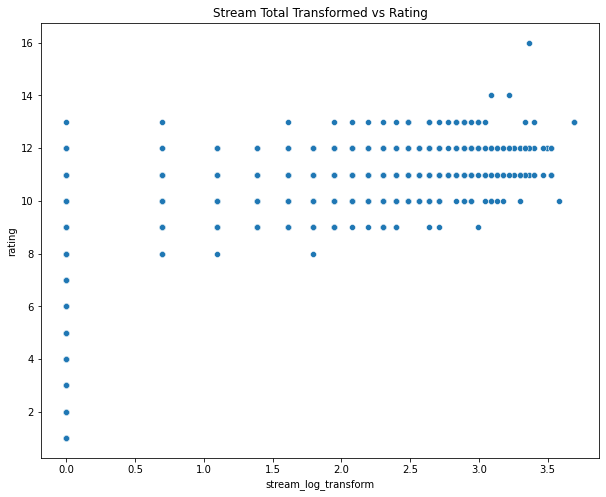

In [66]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = not_stam_df, x = 'stream_log_transform', y = 'rating')
steps.set(title = "Stream Total Transformed vs Rating");

In [67]:
stam_df['stream_log_transform'] = np.where(stam_df['stream_total'] > 0, np.log(stam_df['stream_total']), stam_df['stream_total'])

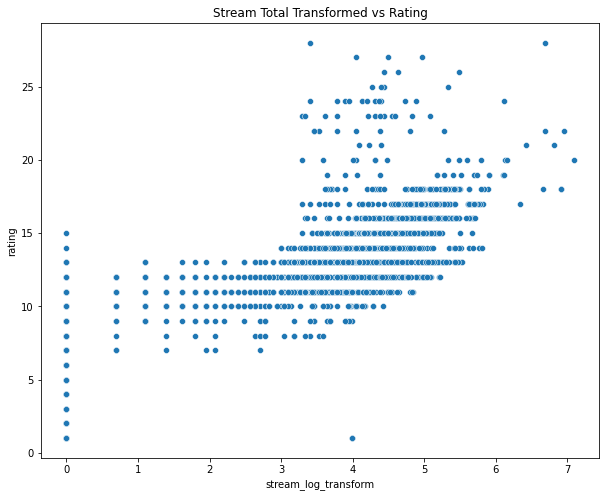

In [68]:
fig, ax = plt.subplots(figsize = (10, 8))
steps = sns.scatterplot(data = stam_df, x = 'stream_log_transform', y = 'rating')
steps.set(title = "Stream Total Transformed vs Rating");

## Data Understanding - viz goes here instead

# First Simple Model - Linear Regression

In [69]:
data = not_stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1)
target1 = not_stam_df['rating']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data, target1, random_state = 42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 42)

In [71]:
scaler = StandardScaler()
lr = LinearRegression()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

lr.fit(X_tr_scaled, y_tr)

LinearRegression()

In [72]:
y_pred = lr.predict(X_tr_scaled)

In [73]:
y_tr[:15]

4254    11.0
2636     9.0
4364     8.0
918     11.0
1342    10.0
2977    10.0
2462     6.0
3070     3.0
1828     1.0
2243     8.0
4336     4.0
291      1.0
3648     9.0
1156     9.0
4118    11.0
Name: rating, dtype: float64

In [74]:
y_pred[:15]

array([11.29731622,  7.73750349,  8.64450728, 11.80277008, 10.21767193,
        9.84962085,  4.46936752,  2.74207797,  1.85313132,  6.83233832,
        4.04295657,  2.74917163,  9.2566458 ,  7.62165548, 11.02620485])

In [75]:
lr.score(X_tr_scaled, y_tr)

0.9504791711620696

In [76]:
y_test = lr.predict(X_val_scaled)

In [77]:
y_test[:15].reshape(-1,1)

array([[ 8.65031294],
       [ 1.84318727],
       [10.48715316],
       [ 4.04951174],
       [ 2.03339995],
       [10.56963663],
       [ 4.25972738],
       [ 8.46639565],
       [ 4.18339527],
       [11.45884037],
       [ 8.27955952],
       [ 1.47913017],
       [ 8.79195897],
       [ 5.28274889],
       [ 4.62800437]])

In [78]:
y_val[:15]

1073     9.0
2405     1.0
3207    11.0
1816     5.0
4747     1.0
4509    10.0
2312     6.0
2645     9.0
3217     5.0
4748    12.0
3197     8.0
3146     1.0
2650    10.0
1429     4.0
4561     5.0
Name: rating, dtype: float64

In [79]:
lr.score(X_val_scaled, y_val)

-1619095.985568941

In [80]:
cross_val_score(lr, X_train, y_train)

array([-5.58269429e+06, -1.06470712e+04,  9.40403961e-01, -2.22569159e+06,
        9.42934565e-01])

In [81]:
lr.coef_

array([ 8.08779275e-02,  2.46706717e+00, -6.38771739e-01, -4.04439945e-02,
        6.76166395e+01, -1.76429445e-02,  1.48352594e-01, -4.22601646e-02,
        1.95168664e+00,  6.62063277e+03, -3.65452782e+04,  3.30961763e+03,
        2.61524963e+04,  3.93731312e+02, -1.75804865e-01, -1.56952100e-02,
       -8.90009227e-02,  1.16290926e-01, -3.37176509e-03,  6.24730522e-02,
       -5.18605124e-02,  3.58313291e-02, -1.69965096e-02,  5.99958609e-02,
       -2.21883743e-02, -4.14352406e-02, -3.35705390e-01, -1.90786743e-01])

## Lasso regression

In [82]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1)

lasso.fit(X_tr_scaled, y_tr)

print(f'LR | Train R^2: {lasso.score(X_tr_scaled, y_tr)} \nLR | Test R^2: {lasso.score(X_val_scaled, y_val)}')
print(f'LR | Val MSE: {mean_squared_error(y_tr, lasso.predict(X_tr_scaled))} \nLR | Val MSE: {mean_squared_error(y_val, lasso.predict(X_val_scaled))}')

LR | Train R^2: 0.8248391605976396 
LR | Test R^2: 0.8282292465172169
LR | Val MSE: 2.2346618130405917 
LR | Val MSE: 2.137753161448089


In [83]:
lasso.coef_

array([-0.        ,  2.39457049, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [84]:
cross_val_score(lasso, X_train, y_train, scoring = 'r2')

array([0.93590651, 0.93644689, 0.92398245, 0.92221264, 0.92669053])

In [85]:
lasso.__dict__

{'alpha': 1,
 'l1_ratio': 1.0,
 'fit_intercept': True,
 'normalize': False,
 'precompute': False,
 'max_iter': 1000,
 'copy_X': True,
 'tol': 0.0001,
 'warm_start': False,
 'positive': False,
 'random_state': None,
 'selection': 'cyclic',
 'n_features_in_': 28,
 'n_iter_': 2,
 'coef_': array([-0.        ,  2.39457049, -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'dual_gap_': 1.8189894035458565e-12,
 'intercept_': 6.698728579325595}

In [86]:
lasso.score(X_val_scaled, y_val)

0.8282292465172169

## Ridge Regression

In [87]:
from sklearn.linear_model import Ridge

ridge = Ridge()

ridge.fit(X_tr_scaled, y_tr)

Ridge()

In [88]:
ridge.score(X_tr_scaled, y_tr), ridge.score(X_val_scaled, y_val)

(0.9384834209334008, 0.9254767257730866)

In [89]:
cross_val_score(ridge, X_train, y_train)

array([-5.46543065e+06, -1.09244423e+04,  9.40393204e-01, -2.16419649e+06,
        9.42929222e-01])

In [90]:
ridge_tr_preds = ridge.predict(X_tr_scaled)
ridge_val_preds = ridge.predict(X_val_scaled)

print(f'Ridge | Train R^2: {ridge.score(X_tr_scaled, y_tr)} \nRidge | Test R^2: {ridge.score(X_val_scaled, y_val)}')
print(f'Ridge | Val MSE: {mean_squared_error(y_tr, ridge_tr_preds)} \nRidge | Val MSE: {mean_squared_error(y_val, ridge_val_preds)}')

Ridge | Train R^2: 0.9384834209334008 
Ridge | Test R^2: 0.9254767257730866
Ridge | Val MSE: 0.7848144058800919 
Ridge | Val MSE: 0.9274708403489372


In [91]:
ridge.coef_

array([ 0.03884251,  2.40416743, -0.5512874 , -0.02295753, -0.16351165,
       -0.0356607 ,  0.15624534,  0.00581154,  1.63052507, -0.16372267,
       -0.17025479, -0.17002525, -0.16139686, -0.17019156, -0.13520666,
       -0.00515054, -0.02884226,  0.19255208,  0.0683865 ,  0.09406264,
       -0.08355435,  0.00665106, -0.00810962,  0.06958033, -0.04806796,
        0.003738  , -0.38139576,  0.06798944])

## Elastic Net

In [92]:
from sklearn.linear_model import ElasticNet

net = ElasticNet()

net.fit(X_tr_scaled, y_tr)

ElasticNet()

In [93]:
net.score(X_tr_scaled, y_tr), net.score(X_val_scaled, y_val)

(0.7877640318693727, 0.6488829142323855)

## Plotting residuals

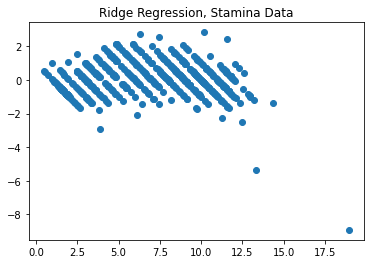

In [96]:
ridge_resids = y_val - ridge_val_preds

plt.scatter(ridge_val_preds, ridge_resids)
plt.title("Ridge Regression, Stamina Data");

hm.

In [97]:
##cross-val score, RMSE
##qqplot, resids

## Polynomial Features

In [98]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

X_tr_poly = poly.fit_transform(X_tr)
X_val_poly = poly.transform(X_val)

In [99]:
linreg = LinearRegression()

linreg.fit(X_tr_poly, y_tr)
linreg.score(X_tr_poly, y_tr), linreg.score(X_val_poly, y_val)

(0.9741612692120221, -1.751320808312364e+19)

In [100]:
ridge_2 = Ridge()

ridge_2.fit(X_tr_poly, y_tr)

ridge_2.score(X_tr_poly, y_tr), ridge_2.score(X_val_poly, y_val)

(0.9756007628441827, -4.5822707152262733e+21)

## Let's try a classifier

In [102]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [103]:
tree.fit(X_tr, y_tr)

DecisionTreeClassifier()

In [104]:
tree.score(X_tr, y_tr), tree.score(X_val, y_val)

(1.0, 0.5323383084577115)

In [105]:
tree_preds = tree.predict(X_val)

In [106]:
tree_preds[:15]

array([ 9.,  1., 10.,  3.,  1., 10.,  4.,  8.,  5., 12.,  8.,  1., 10.,
        5.,  4.])

In [107]:
y_val[:15]

1073     9.0
2405     1.0
3207    11.0
1816     5.0
4747     1.0
4509    10.0
2312     6.0
2645     9.0
3217     5.0
4748    12.0
3197     8.0
3146     1.0
2650    10.0
1429     4.0
4561     5.0
Name: rating, dtype: float64

In [108]:
sgd = SGDClassifier()

sgd.fit(X_tr, y_tr)

SGDClassifier()

In [109]:
sgd.score(X_tr, y_tr), sgd.score(X_val, y_val)

(0.11719181868435599, 0.12603648424543948)

## Multiclass with Logistic Regression

In [110]:
set(y_val.values), set(y_tr.values)

({1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0},
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 16.0})

In [111]:
clf = LogisticRegression(penalty = 'l2')
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

clf.fit(X_tr_scaled, y_tr)

LogisticRegression()

In [112]:
train_preds = clf.predict(X_tr_scaled)
val_preds = clf.predict(X_val_scaled)

In [113]:
train_preds

array([11.,  9.,  9., ...,  9.,  4.,  3.])

In [114]:
y_tr

4254    11.0
2636     9.0
4364     8.0
918     11.0
1342    10.0
        ... 
105      5.0
219      3.0
364      9.0
737      6.0
210      3.0
Name: rating, Length: 1809, dtype: float64

In [115]:
diffs = y_tr - train_preds

In [122]:
len(diffs)

1809

In [116]:
diffs[:20]

4254    0.0
2636    0.0
4364   -1.0
918     0.0
1342    0.0
2977    0.0
2462    2.0
3070    1.0
1828    0.0
2243    1.0
4336    0.0
291    -1.0
3648    0.0
1156    1.0
4118   -1.0
2550    0.0
3515   -1.0
2525    0.0
2236    0.0
1817    2.0
Name: rating, dtype: float64

In [117]:
y_tr[:20]

4254    11.0
2636     9.0
4364     8.0
918     11.0
1342    10.0
2977    10.0
2462     6.0
3070     3.0
1828     1.0
2243     8.0
4336     4.0
291      1.0
3648     9.0
1156     9.0
4118    11.0
2550     1.0
3515     6.0
2525     1.0
2236     3.0
1817     3.0
Name: rating, dtype: float64

In [118]:
train_preds[:20]

array([11.,  9.,  9., 11., 10., 10.,  4.,  2.,  1.,  7.,  4.,  2.,  9.,
        8., 12.,  1.,  7.,  1.,  3.,  1.])

In [119]:
accuracy_score(y_tr, train_preds)

0.5992260917634052

In [120]:
accuracy_score(y_val, val_preds)

0.5174129353233831

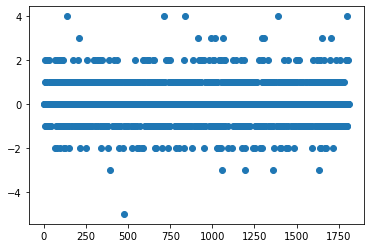

In [123]:
x_ = np.linspace(1, 1809, 1809)
plt.scatter(x_, diffs)

Looks like the majority of errors happened within 1 of the true value, but there are a few very far-off predictions.

## Iterative Model Building

In [124]:
##steps to consider:
#PCA?
#Scaling
#
#Power transform
#Pipeline with a custom transform
#Feature extraction
#Gridsearch

## GridSearching through ridge parameters

In [125]:
ridge_params = {'alpha': [.1, .5, 1, 2, 5, 8],
                'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [126]:
ridge_grid = GridSearchCV(estimator = ridge, param_grid = ridge_params, scoring = 'r2')

In [127]:
ridge_grid.fit(X_tr_scaled, y_tr)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.5, 1, 2, 5, 8],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             scoring='r2')

In [128]:
ridge_grid.best_params_

{'alpha': 1, 'solver': 'auto'}

## Using GridSearch params and applying a power transformer

In [129]:
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer()
X_tr_power = power.fit_transform(X_tr)

X_val_power = power.transform(X_val)

X_train_power = power.transform(X_train)

In [130]:
ridge = Ridge(alpha = .1)

ridge.fit(X_tr_power, y_tr)

Ridge(alpha=0.1)

In [131]:
ridge.score(X_tr_power, y_tr), ridge.score(X_val_power, y_val)

(0.9602324028769168, 0.9593790946124193)

In [132]:
cross_val_score(ridge, X_train_power, y_train).mean()

0.9584482897966954

improvement!

## Let's add scaling back in

In [133]:
power = PowerTransformer()
scaler = StandardScaler()

X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

X_tr_power = power.fit_transform(X_tr_scaled)
X_val_power = power.transform(X_val_scaled)

X_train_power = power.transform(scaler.transform(X_train))

In [134]:
ridge1 = Ridge(alpha = .1)

ridge1.fit(X_tr_power, y_tr)

Ridge(alpha=0.1)

In [135]:
ridge1.score(X_tr_power, y_tr), ridge1.score(X_val_power, y_val)

(0.9623502421714752, 0.9420190630923811)

In [136]:
cross_val_score(ridge1, X_train_power, y_train).mean()

0.9558349213881613

## PCA??

In [137]:
pca = PCA()
scaler1 = StandardScaler()
power1 = PowerTransformer()


X_tr_pca = pca.fit_transform(X_tr)
X_val_pca = pca.transform(X_val)
X_train_pca = pca.transform(X_train)


X_tr_transformed = power1.fit_transform(scaler1.fit_transform(X_tr_pca))
X_val_transformed = power1.transform(scaler1.transform(X_val_pca))

X_train_transformed = power1.transform(scaler1.transform(X_train_pca))

In [138]:
ridge2 = Ridge(alpha = .1)

ridge2.fit(X_tr_transformed, y_tr)

Ridge(alpha=0.1)

In [139]:
ridge2.score(X_tr_transformed, y_tr), ridge2.score(X_val_transformed, y_val)

(0.9556026314927788, -69411377004252.36)

In [140]:
cross_val_score(ridge2, X_train_transformed, y_train).mean()

-5180620164.77369

In [141]:
ridge2_preds = ridge2.predict(X_val_transformed)

In [142]:
ridge2_resids = y_val - ridge2_preds

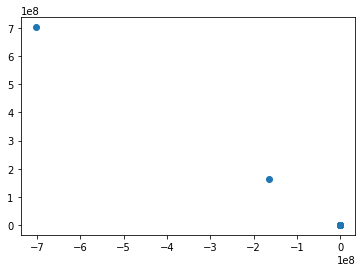

In [143]:
plt.scatter(ridge2_resids, ridge2_preds);

In [144]:
ridge2_preds[:20].reshape(-1,1)

array([[ 8.63155618],
       [ 1.59317319],
       [10.40725715],
       [ 4.06086922],
       [ 1.94293314],
       [10.47024055],
       [ 4.2756782 ],
       [ 8.35101886],
       [ 4.37987834],
       [11.45880842],
       [ 8.25760893],
       [ 1.44734427],
       [ 8.78168132],
       [ 5.296372  ],
       [ 4.78166259],
       [ 4.18930554],
       [ 9.30031973],
       [ 6.97019326],
       [10.95777485],
       [11.31967855]])

In [145]:
y_val[:20]

1073     9.0
2405     1.0
3207    11.0
1816     5.0
4747     1.0
4509    10.0
2312     6.0
2645     9.0
3217     5.0
4748    12.0
3197     8.0
3146     1.0
2650    10.0
1429     4.0
4561     5.0
2597     5.0
2449    10.0
3468     7.0
3018    11.0
2960    11.0
Name: rating, dtype: float64

Let's introduce a couple categorical columns and see if this impacts the data at all.

In [146]:
data = not_stam_df.drop(columns = ['title', 'difficulty', 'rating'], inplace = False)
target = not_stam_df['rating']

In [147]:
data = not_stam_df.drop(columns = ['title', 'difficulty', 'rating'], inplace = False)
target = not_stam_df['rating']
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42)

In [148]:
X_train_num = X_train.drop(columns = 'artist', inplace = False)
X_train_cat = X_train[['artist']]

In [149]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
X_train_enc = ohe.fit_transform(X_train_cat)

In [150]:
X_train_enc = pd.DataFrame(X_train_enc,
    columns=ohe.categories_[0],
    index=X_train.index
)

In [151]:
X_train = pd.concat([X_train_num, X_train_enc], axis = 1)

Okay, let's try a ridge regression with encoded and scaled data.

In [152]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor',Ridge(alpha = .1, solver = 'auto'))]
pipe = Pipeline(estimators)

In [153]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.1))])

In [154]:
cross_val_score(pipe, X_train, y_train)

array([0.95998359, 0.9551359 , 0.95527677, 0.95916315, 0.96130045])

In [155]:
cross_val_score(pipe, X_train, y_train).mean()

0.9581719740197574

In [156]:
pipe.steps[2][1].__dict__

{'alpha': 0.1,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 746,
 'coef_': array([ 2.46031829e-01,  7.24366953e-01, -3.58447063e-01, -8.11528683e-02,
         5.07637053e-02,  4.11627238e-02,  1.16392872e-01, -1.85468084e-02,
         3.06830806e+00,  2.52472920e+00, -6.50962524e+00, -2.87912450e+00,
         5.71815185e+00, -2.85044580e-01, -1.01423852e-01, -7.50926196e-03,
        -1.44198178e-03,  7.49873816e-02,  9.70707042e-02,  5.15308748e-02,
         7.78849771e-03,  6.11337406e-02, -3.43050963e-02,  1.58032286e-02,
         4.91459116e-02,  1.34725042e-02, -2.56285884e-01,  2.16798988e-01,
         5.65093781e-03, -6.20801091e-03, -1.38408249e-02, -1.60265000e-02,
         1.32168011e-02, -7.65085361e-03, -1.03813086e-03, -1.12752449e-02,
        -3.16144109e-03,  5.21181624e-02,  3.26974100e-02,  6.49619019e-03,
        -1.32113002e-02, -7.75040780e-03, -2.45895259e

Generally good scores here, but it seems like adding in a very sparse categorical hardly improved performance but increased computational time considerably! 

### run timeit next time to compare performance.

In [157]:
#back to numerical data only
not_stam_data = not_stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], inplace = False)
not_stam_target = not_stam_df['rating']

In [158]:
X_train_notstam, X_test_notstam, y_train_notstam, y_test_notstam = train_test_split(not_stam_data, not_stam_target, random_state = 42)

In [159]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor',Ridge(alpha = .3, solver = 'auto'))]
not_stam_pipe = Pipeline(estimators)

In [160]:
not_stam_pipe.fit(X_train_notstam, y_train_notstam)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3))])

In [161]:
cross_val_score(not_stam_pipe, X_train_notstam, y_train_notstam)

array([0.96319552, 0.96064122, 0.95741694, 0.95891357, 0.96071448])

In [162]:
cross_val_score(not_stam_pipe, X_train_notstam, y_train_notstam).mean()

0.9601763455051143

In [163]:
not_stam_pipe.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 28,
 'coef_': array([ 2.65560911e-01,  7.33833541e-01, -3.95932304e-01, -5.56595304e-02,
         2.67483035e-02, -7.69531190e-02,  1.51919453e-01, -1.10810163e-01,
         3.01014768e+00,  2.90035237e+00, -6.68064555e+00, -2.15594397e+00,
         5.73208008e+00, -4.39503898e-01, -9.64156202e-02,  3.84184405e-03,
         9.77186313e-06,  6.19726581e-02,  8.61872659e-02,  1.80308488e-02,
        -2.20060827e-02, -3.48033704e-03,  5.88348322e-03,  2.90765703e-02,
         9.32455035e-03,  7.08383099e-02, -2.21741045e-01,  1.64395570e-01]),
 'n_iter_': None,
 'intercept_': 6.7280265339966965}

Coefficients over abs(.75) are indexed as:  
`1, 8, 9, 10, 12`  
corresponding to:  
`step_count`  
`song_nps`  
`nps_per_measure_max`  
`nps_per_measure_avg`   - negative coefficient??   
`nps_per_measure_std`

In [164]:
X_train_notstam.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_log_transform'],
      dtype='object')

So far, the most successful approach has been using scaled and power-transformed data for non-stamina estimation.

In [165]:
y_preds_notstam = not_stam_pipe.predict(X_train_notstam)

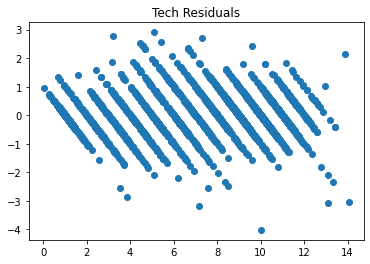

In [167]:
resids = y_train_notstam - y_preds_notstam
plt.scatter(y_preds_notstam, resids)
plt.title("Tech Residuals");

## Now for stamina data

In [168]:
stam_data = stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1, inplace = False)
stam_target = stam_df['rating']

In [169]:
X_train_stam, X_test_stam, y_train_stam, y_test_stam = train_test_split(stam_data, stam_target, random_state = 1)

In [170]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor', Ridge(alpha = .3))]
stam_pipe = Pipeline(estimators)

In [171]:
stam_pipe.fit(X_train_stam, y_train_stam)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3))])

In [172]:
cross_val_score(stam_pipe, X_train_stam, y_train_stam)

array([0.96568839, 0.97449101, 0.9770322 , 0.95134486, 0.95750866])

In [173]:
cross_val_score(stam_pipe, X_train_stam, y_train_stam).mean()

0.965213023290446

In [174]:
stam_pipe.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'auto',
 'random_state': None,
 'n_features_in_': 37,
 'coef_': array([ 0.22029509,  2.14501616, -0.85598663, -0.16006598,  0.03945674,
        -0.00372778,  0.07188038,  0.04027581,  1.55408882,  0.87372049,
         0.34829456, -0.47584339,  1.29253936, -0.10341334,  0.03875156,
         0.00995711,  0.02190598,  0.1023249 , -0.0853135 ,  0.00463496,
         0.11495888,  0.02672858, -0.09257425,  0.03035042, -0.02252637,
        -0.04424371, -0.34740644,  0.48670106, -0.08490525,  0.14921488,
         0.12770471, -0.58955639,  0.09400227, -0.07006145, -0.18717944,
        -0.0419063 , -0.47056476]),
 'n_iter_': None,
 'intercept_': 12.555862831858407}

Coefficients near or over abs(.75) are indexed as:  
`1, 2, 8, 9, 12, 26`  
corresponding to:  
`step_count`  
`measure_count` - negative ?? - possible - longer but less dense   
`song_nps`  
`nps_per_measure_max`  
`nps_per_measure_std`  
`stream_total`

In [175]:
X_train_stam.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg',
       'stream_size_std', 'break_count', 'break_size_max', 'break_size_avg',
       'break_total', 'break_size_std', 'stream_log_transform'],
      dtype='object')

In [176]:
y_preds_stam = stam_pipe.predict(X_train_stam)

In [177]:
y_train_stam[:20]

1079    13.0
2667    11.0
377     17.0
1733    18.0
1037    14.0
272     14.0
673     10.0
2557     8.0
2892    13.0
1941    16.0
2798    11.0
2336    14.0
2693    10.0
502     18.0
948     15.0
170     18.0
283     12.0
2748    10.0
2813    16.0
289     13.0
Name: rating, dtype: float64

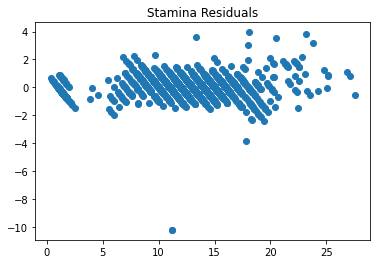

In [178]:
resids = y_train_stam - y_preds_stam
plt.scatter(y_preds_stam, resids)
plt.title("Stamina Residuals");

In [179]:
min(resids)

-10.222129904615434

In [180]:
np.where(resids == 
-10.18823123265942)

(array([], dtype=int64),)

In [181]:
X_train_stam.iloc[1278]

song_seconds               200.000000
step_count                1184.000000
measure_count              115.000000
bpm_weighted_avg           138.000000
bpm_max                    138.000000
bpm_min                    138.000000
bpm_mode                   138.000000
bpm_change_count             0.000000
song_nps                     5.920000
nps_per_measure_max          9.200000
nps_per_measure_avg          5.920000
nps_per_measure_median       5.750000
nps_per_measure_std          3.454179
nps_per_measure_mode         9.200000
jumps                        6.000000
hands                        0.000000
quads                        0.000000
holds                       43.000000
mines                       55.000000
rolls                        0.000000
crossovers                 100.000000
footswitches                19.000000
crossover_footswitches      10.000000
jacks                        7.000000
invalid_crossovers           7.000000
stop_count                   0.000000
stream_total

In [182]:
stam_df.loc[stam_df['step_count'] == 1184]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating,stream_log_transform
13,Dragostea Din Tei,O-Zone,200.000000,1184,115,138.0,138.0,138.0,138.0,0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6,0,0,43,55,0,10,19,9,7,7,0,54,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Challenge,11.0,3.988984
14,Dragostea Din Tei,O-Zone,200.000000,1184,115,138.0,138.0,138.0,138.0,0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6,0,0,43,55,0,100,19,10,7,7,0,54,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Edit,1.0,3.988984
15,Dragostea Din Tei,O-Zone,200.000000,1184,115,138.0,138.0,138.0,138.0,0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6,0,0,43,55,0,100,19,10,7,7,0,54,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Edit,1.0,3.988984
365,Gott,Hommarju,119.384615,1184,97,195.0,195.0,195.0,195.0,0,9.917526,13.0,9.917526,13.000,4.454784,13.0,6,0,0,10,0,2,0,2,0,0,2,0,60,7.0,32.0,8.571429,11.530498,8.0,17.0,4.625000,37.0,5.289815,Challenge,15.0,4.094345
904,Bulletproof,La Roux,206.829268,1184,106,123.0,123.0,123.0,123.0,0,5.724528,8.2,5.724528,5.125,2.271658,8.2,0,0,0,30,0,1,8,14,7,5,12,0,42,3.0,16.0,14.000000,2.645751,4.0,25.0,16.000000,64.0,8.246211,Challenge,11.0,3.737670


In [183]:
X_train_stam.iloc[1765]

song_seconds               200.000000
step_count                1184.000000
measure_count              115.000000
bpm_weighted_avg           138.000000
bpm_max                    138.000000
bpm_min                    138.000000
bpm_mode                   138.000000
bpm_change_count             0.000000
song_nps                     5.920000
nps_per_measure_max          9.200000
nps_per_measure_avg          5.920000
nps_per_measure_median       5.750000
nps_per_measure_std          3.454179
nps_per_measure_mode         9.200000
jumps                        6.000000
hands                        0.000000
quads                        0.000000
holds                       43.000000
mines                       55.000000
rolls                        0.000000
crossovers                 100.000000
footswitches                19.000000
crossover_footswitches      10.000000
jacks                        7.000000
invalid_crossovers           7.000000
stop_count                   0.000000
stream_total

So the huge outlier is.. Dragostea Din Tei. Haha.

## Try XGBoost

In [184]:
data2 = not_stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1, inplace = False)
target2 = not_stam_df['rating']

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, random_state = 3)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train2, y_train2, random_state = 2 )

In [185]:
xgb = XGBRegressor()
scaler_xgb = StandardScaler()
power_xgb = PowerTransformer()

X_TR = power_xgb.fit_transform(scaler_xgb.fit_transform(X_train2))
X_VAL = power_xgb.transform(scaler_xgb.transform(X_val2))

In [186]:
xgb.fit(X_TR, y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [187]:
xgb.score(X_TR, y_train2)

0.9990740247026868

In [188]:
xgb.score(X_VAL, y_val2)

0.9991699056958481

In [195]:
val_preds2 = xgb.predict(X_VAL)

In [197]:
val_preds2[:20].reshape(-1,1)

array([[ 2.8571265],
       [ 0.9959943],
       [ 5.0917897],
       [10.080598 ],
       [11.993051 ],
       [ 7.048847 ],
       [ 1.0112047],
       [ 0.9788779],
       [ 1.0086694],
       [ 8.969936 ],
       [ 9.996919 ],
       [ 2.0615253],
       [ 2.1667495],
       [10.050992 ],
       [ 9.005819 ],
       [11.034658 ],
       [ 5.343277 ],
       [ 8.902935 ],
       [ 6.019734 ],
       [ 1.055007 ]], dtype=float32)

In [191]:
y_val2[:20]

1853     3.0
1884     1.0
412      5.0
2104    10.0
1809    12.0
4659     7.0
4767     1.0
2515     1.0
3931     1.0
527      9.0
3344    10.0
2571     2.0
3508     2.0
1519    10.0
4173     9.0
1722    11.0
4565     5.0
2434     9.0
183      6.0
3996     1.0
Name: rating, dtype: float64

In [192]:
xgb.__dict__

{'n_estimators': 100,
 'objective': 'reg:squarederror',
 'max_depth': None,
 'learning_rate': None,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': None,
 'colsample_bytree': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'kwargs': {},
 'random_state': None,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': 'gain',
 'gpu_id': None,
 'validate_parameters': None,
 'n_features_in_': 28,
 '_Booster': <xgboost.core.Booster at 0x2d3dd5b61f0>}

In [193]:
xgb.feature_importances_

array([7.7446335e-04, 1.6123362e-02, 1.6925700e-03, 1.5704704e-03,
       2.4743190e-03, 1.4109068e-03, 3.4799518e-03, 1.4099154e-03,
       7.2000659e-01, 4.8887774e-02, 1.0693337e-01, 9.7557448e-04,
       1.3630631e-02, 1.8765606e-03, 1.1926473e-03, 1.2260030e-03,
       1.2435661e-04, 1.7272191e-03, 2.5876728e-03, 9.8952069e-04,
       8.9400203e-04, 1.0202372e-03, 8.0109370e-04, 1.6236990e-03,
       9.3971431e-04, 4.0024905e-03, 6.1624873e-02, 0.0000000e+00],
      dtype=float32)

In [211]:
X_val2.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_log_transform'],
      dtype='object')

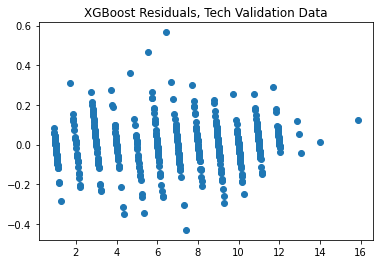

In [198]:
resids2 = y_val2 - val_preds2
plt.scatter(val_preds2, resids2)
plt.title("XGBoost Residuals, Tech Validation Data");

## Stamina Data

In [199]:
data3 = stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1, inplace = False)
target3 = stam_df['rating']

X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, random_state = 3)
X_tr3, X_val3, y_tr3, y_val3 = train_test_split(X_train3, y_train3, random_state = 2)

In [200]:
xgb3 = XGBRegressor()
scaler_xgb3 = StandardScaler()
power_xgb3 = PowerTransformer()

X_TR3 = power_xgb3.fit_transform(scaler_xgb3.fit_transform(X_train3))
X_VAL3 = power_xgb3.transform(scaler_xgb3.transform(X_val3))

In [201]:
xgb3.fit(X_TR3, y_train3)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
xgb3.__dict__

{'n_estimators': 100,
 'objective': 'reg:squarederror',
 'max_depth': None,
 'learning_rate': None,
 'verbosity': None,
 'booster': None,
 'tree_method': None,
 'gamma': None,
 'min_child_weight': None,
 'max_delta_step': None,
 'subsample': None,
 'colsample_bytree': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'base_score': None,
 'missing': nan,
 'num_parallel_tree': None,
 'kwargs': {},
 'random_state': None,
 'n_jobs': None,
 'monotone_constraints': None,
 'interaction_constraints': None,
 'importance_type': 'gain',
 'gpu_id': None,
 'validate_parameters': None,
 'n_features_in_': 37,
 '_Booster': <xgboost.core.Booster at 0x2d3dd5cd250>}

In [202]:
xgb3.score(X_TR3, y_train3)

0.9997806123160393

In [203]:
xgb3.score(X_VAL3, y_val3)

0.9998002160765326

In [204]:
val_preds3 = xgb3.predict(X_VAL3)

In [205]:
val_preds3[:20].reshape(-1, 1)

array([[17.064268 ],
       [ 0.9911989],
       [ 9.016423 ],
       [ 7.026699 ],
       [15.012361 ],
       [12.990537 ],
       [ 1.026    ],
       [15.001181 ],
       [12.983392 ],
       [13.00052  ],
       [12.808005 ],
       [15.015807 ],
       [11.970904 ],
       [ 8.079988 ],
       [ 8.992613 ],
       [14.045317 ],
       [15.024385 ],
       [10.02632  ],
       [14.948839 ],
       [16.047276 ]], dtype=float32)

In [206]:
y_val3[:20]

1583    17.0
2040     1.0
1808     9.0
2617     7.0
403     15.0
1350    13.0
1956     1.0
876     15.0
945     13.0
992     13.0
2376    13.0
1958    15.0
295     12.0
2514     8.0
2491     9.0
987     14.0
208     15.0
1503    10.0
1160    15.0
2183    16.0
Name: rating, dtype: float64

In [207]:
xgb3.feature_importances_

array([1.3221041e-04, 2.3254873e-03, 6.3019525e-04, 2.4790590e-04,
       1.1451108e-03, 5.4969947e-04, 1.0890700e-03, 5.5543479e-04,
       3.4478787e-02, 1.5238686e-01, 7.4669307e-01, 4.3483661e-03,
       8.3655454e-03, 2.4146821e-02, 2.7541746e-04, 0.0000000e+00,
       3.2864610e-04, 3.6646481e-04, 2.9264428e-04, 2.2444266e-04,
       4.9708579e-03, 5.7718367e-04, 5.0480961e-04, 2.6100929e-04,
       3.2694661e-04, 5.3450131e-05, 9.4191357e-03, 1.9590484e-04,
       1.2674959e-03, 5.5438286e-04, 6.8853993e-04, 9.8019314e-04,
       4.2828216e-04, 4.1799361e-04, 4.0933519e-04, 3.6235285e-04,
       0.0000000e+00], dtype=float32)

In [208]:
X_val3.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg',
       'stream_size_std', 'break_count', 'break_size_max', 'break_size_avg',
       'break_total', 'break_size_std', 'stream_log_transform'],
      dtype='object')

In [209]:
resids3 = y_val3 - val_preds3

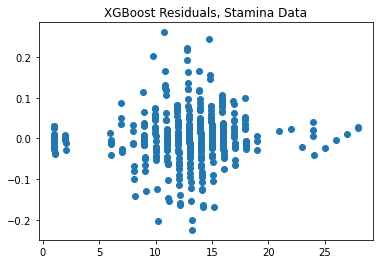

In [210]:
plt.scatter(val_preds3, resids3)
plt.title("XGBoost Residuals, Stamina Data");

In [220]:
from src.summarize import summarize

Max NPS and NPS per measure were the most important features in both data sets.

In [226]:
#to do
# NPS *2 feature -- 
# classifier model for string difficulty judgments
# START A NEW NOTEBOOK FOR CLEANED STUFF
# READ ABOUT FLASK - start making some headway here
# MORE DATA CLEANING - outliers??


In [215]:
xgb_params = {
        'eta':[.7, .9, 1.1],
        'max_depth': [5, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, .5, 1],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0],
        'n_estimators': [100, 120]
            }

grid = GridSearchCV(estimator = xgb, param_grid = xgb_params, scoring = 'r2')

grid.fit(X_VAL, y_val2)

GridSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             param_grid={

In [216]:
grid.best_params_

{'eta': 0.7,
 'gamma': 1.0,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 100,
 'reg_lambda': 5.0}

# Classifier Model for String Difficulty

In [229]:
string_data = stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1, inplace = False)
string_target = stam_df['difficulty']

X_trains, X_tests, y_trains, y_tests = train_test_split(string_data, string_target, random_state = 3)
X_trs, X_vals, y_trs, y_vals = train_test_split(X_trains, y_trains, random_state = 2)

In [237]:
classify = XGBClassifier()
ss = StandardScaler()
pt = PowerTransformer()

X_trs_scaled = scaler.fit_transform(X_trs)
X_vals_scaled = scaler.transform(X_vals)

classify.fit(X_trs_scaled, y_trs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [238]:
pred = classify.predict(X_vals_scaled)

In [239]:
accuracy_score(y_vals, pred)

0.577433628318584

# Data Explanation

# Final Model

# Summary / Conclusions

# Next Steps